<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Singapore Housing Data and Kaggle Challenge

### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Modelling](#Data-Modelling)
- [Evaluation](#Evaluation)
- [Other Exploration and Graphs](#other-exploration-and-graphs)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Background

Housing Development Board is the sole agency for public housing in Singapore. This project will use regression models on a dataset of transacted resale HDB units to predict the resale price of HDB units. 


### Data Source

Data is downloaded from the [Kaggle challenge](#https://www.kaggle.com/competitions/dsi-sg-project-2-regression-challenge-hdb-price/data).

There are 2 datasets included in the [`data`](../data/) folder for this project.

* [`test.csv`](../data/test.csv): Test data from Kaggle to predict resale prices for submission into the Kaggle challenge
* [`train.csv`](../data/train.csv): Training dataset from Kaggle

## Problem Statement

As property buyers in Singapore, the affordability of a HDB unit and potential factors that can influence the price are of interest because this can guide them in their planning process before making a purchase.
We make use of a regression model to give insights to prospective buyers on factors relating to the HDB unit that affect resale prices.

### Outside Research

Sources to understand HDB data and policies. As well as external studies to explore other potential factors affecting resale price that is not available in the dataset.

Sources from HDB, used for re-categorising and exploration of data:
- https://www.hdb.gov.sg/about-us/history/town-planning
- https://www.hdb.gov.sg/residential/buying-a-flat/finding-a-flat/types-of-flats 
- https://www.hdb.gov.sg/-/media/doc/CCG/20082023-Annexes/Annex-A1.ashx
- https://www.hdb.gov.sg/about-us/history/hdb-towns-your-home

Information on other factors:
- https://www.businesstimes.com.sg/property/mobile-spotlight/summary-singapores-property-cooling-measures-1996-present-day
- https://www.channelnewsasia.com/singapore/property-cooling-measures-hdb-resale-prices-2013-2018-each-singapore-town-2385831
- https://www.propertyguru.com.sg/property-guides/how-the-ethnic-quota-can-affect-your-sellingbuying-ability-6747
- https://www.straitstimes.com/singapore/housing/sounds-awful-cant-sleep-cant-talk-because-of-noise
- https://cos.sg/blog-post/outside-noise-could-affect-home-prices/

--- 


### Data Dictionary

For the data dictionary of the Kaggle data set, refer to [Kaggle challenge](#https://www.kaggle.com/competitions/dsi-sg-project-2-regression-challenge-hdb-price/data). The below will explain the engineered features based on the EDA.

|Feature|Type|Dataset|Description|
|---|---|---|---|
|hdb_age_transaction|int|train.csv|The age of the HDB at the point of transaction, starting from the lease commencement date|
|units_per_floor|float|train.csv|The average number of units in each floor of the block|
|has_rental|int|train.csv|Whether the block of the unit has rental units|
|region_maturity|string|train.csv|Classification of HDB region and estate maturity based on HDB's definition on towns|
|model_category|string|train.csv|General classification of HDB's flat model|


---

In [1]:
# traditional mandate of imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter

import seaborn as sns
import matplotlib.dates as dates
import datetime
import statsmodels.api as sm

# sklearn imports
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Data Import and Cleaning

In [3]:
#0. Import data sets
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

train_data['source'] = 'Train'
test_data['source'] = 'Test'

train_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)


C:\Users\user\AppData\Local\Temp\ipykernel_17684\1716473379.py:3: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('../data/test.csv')


Combines training and testing data under the name `train_data` and add a column to denote the source data for the rows.

This is to pass the testing data through the same EDA processing as training data and will eventually be separated before the modelling.

In [4]:
test_ids = test_data[['id']].copy()
test_ids

id
0      114982
1       95653
2       40303
3      109506
4      100149
...       ...
16732   23347
16733   54003
16734  128921
16735   69352
16736  146210

[16737 rows x 1 columns]

Store a complete list of all the ids from `test_data`

In [5]:
train_data = train_data.rename(columns=str.lower)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62448 entries, 0 to 62447
Data columns (total 78 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         62448 non-null  int64  
 1   tranc_yearmonth            62448 non-null  object 
 2   town                       62448 non-null  object 
 3   flat_type                  62448 non-null  object 
 4   block                      62448 non-null  object 
 5   street_name                62448 non-null  object 
 6   storey_range               62448 non-null  object 
 7   floor_area_sqm             62448 non-null  float64
 8   flat_model                 62448 non-null  object 
 9   lease_commence_date        62448 non-null  int64  
 10  resale_price               45711 non-null  float64
 11  tranc_year                 62448 non-null  int64  
 12  tranc_month                62448 non-null  int64  
 13  mid_storey                 62448 non-null  int

There are nulls in the `_within_` columns for malls and hawkers. Based on the data, it is reasonable to understand the nulls as zero, hence we fill the columms containing null as zero.

In [7]:
# Get the column names with '_Within_'
within_cols = [col for col in train_data.columns if '_within_' in col]
within_cols

['mall_within_500m',
 'mall_within_1km',
 'mall_within_2km',
 'hawker_within_500m',
 'hawker_within_1km',
 'hawker_within_2km']

In [8]:
train_data[within_cols] = train_data[within_cols].fillna(value=0)
train_data[within_cols] 

mall_within_500m  mall_within_1km  mall_within_2km  hawker_within_500m  \
0                   0.0              0.0              0.0                 1.0   
1                   0.0              0.0              0.0                 1.0   
2                   0.0              0.0              0.0                 1.0   
3                   0.0              0.0              0.0                 1.0   
4                   0.0              0.0              0.0                 1.0   
...                 ...              ...              ...                 ...   
62443               0.0              0.0              2.0                 1.0   
62444               0.0              2.0              5.0                 0.0   
62445               0.0              2.0              3.0                 0.0   
62446               0.0              1.0              3.0                 0.0   
62447               0.0              1.0              1.0                 0.0   

       hawker_within_1km  hawker_within_2km  
0                    1.0                1.0  
1                    1.0                1.0  
2                    1.0                1.0  
3                    1.0                1.0  
4                    1.0                1.0  
...                  ...                ...  
62443                2.0                8.0  
62444                0.0                0.0  
62445                0.0                0.0  
62446                1.0                7.0  
62447                1.0                1.0  

[62448 rows x 6 columns]

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62448 entries, 0 to 62447
Data columns (total 78 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         62448 non-null  int64  
 1   tranc_yearmonth            62448 non-null  object 
 2   town                       62448 non-null  object 
 3   flat_type                  62448 non-null  object 
 4   block                      62448 non-null  object 
 5   street_name                62448 non-null  object 
 6   storey_range               62448 non-null  object 
 7   floor_area_sqm             62448 non-null  float64
 8   flat_model                 62448 non-null  object 
 9   lease_commence_date        62448 non-null  int64  
 10  resale_price               45711 non-null  float64
 11  tranc_year                 62448 non-null  int64  
 12  tranc_month                62448 non-null  int64  
 13  mid_storey                 62448 non-null  int

In [10]:
train_data['mall_nearest_distance'].isnull().sum() * 100 / len(train_data)

0.6085062772226493

However, there are still nulls in the 'Mall_Nearest_Distance' column. This amounts to only 0.55%, so we opt to drop them, assuming that they are randomly missing.

In [11]:
train_data[pd.to_numeric(train_data['postal'], errors='coerce').isnull()]['postal'].unique()

array(['NIL'], dtype=object)

In [12]:
train_data[pd.to_numeric(train_data['postal'], errors='coerce').isnull()]['postal'].count()

2

In [13]:
train_data[pd.to_numeric(train_data['postal'], errors='coerce').isnull()]['address'].unique()

array(['238, COMPASSVALE WALK'], dtype=object)

In [14]:
train_data[train_data['address'].isin( ['215, CHOA CHU KANG CTRL', '238, COMPASSVALE WALK'])]

id tranc_yearmonth      town flat_type block       street_name  \
50848  162636         2016-07  SENGKANG    4 ROOM   238  COMPASSVALE WALK   
56466  162652         2015-05  SENGKANG    5 ROOM   238  COMPASSVALE WALK   

      storey_range  floor_area_sqm flat_model  lease_commence_date  \
50848     16 TO 18           100.0    Model A                 1999   
56466     16 TO 18           122.0   Improved                 1999   

       resale_price  tranc_year  tranc_month  mid_storey  lower  upper  mid  \
50848           NaN        2016            7          17     16     18   17   
56466           NaN        2015            5          17     16     18   17   

        full_flat_type                address  floor_area_sqft  hdb_age  \
50848   4 ROOM Model A  238, COMPASSVALE WALK         1076.400       22   
56466  5 ROOM Improved  238, COMPASSVALE WALK         1313.208       22   

       max_floor_lvl  year_completed residential commercial market_hawker  \
50848             16            1998           Y          N             N   
56466             16            1998           Y          N             N   

      multistorey_carpark precinct_pavilion  total_dwelling_units  1room_sold  \
50848                   N                 N                   137           0   
56466                   N                 N                   137           0   

       2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  \
50848           0           0          92          45          0   
56466           0           0          92          45          0   

       multigen_sold  studio_apartment_sold  1room_rental  2room_rental  \
50848              0                      0             0             0   
56466              0                      0             0             0   

       3room_rental  other_room_rental postal  latitude   longitude  \
50848             0                  0    NIL   1.39044  103.898664   
56466             0                  0    NIL   1.39044  103.898664   

      planning_area  mall_nearest_distance  mall_within_500m  mall_within_1km  \
50848      Sengkang             448.929181               1.0              3.0   
56466      Sengkang             448.929181               1.0              3.0   

       mall_within_2km  hawker_nearest_distance  hawker_within_500m  \
50848              6.0              2449.012307                 0.0   
56466              6.0              2449.012307                 0.0   

       hawker_within_1km  hawker_within_2km  hawker_food_stalls  \
50848                0.0                0.0                  40   
56466                0.0                0.0                  40   

       hawker_market_stalls  mrt_nearest_distance  mrt_name  bus_interchange  \
50848                     0            394.275271  Sengkang                1   
56466                     0            394.275271  Sengkang                1   

       mrt_interchange  mrt_latitude  mrt_longitude  \
50848                1       1.39244     103.895735   
56466                1       1.39244     103.895735   

       bus_stop_nearest_distance bus_stop_name  bus_stop_latitude  \
50848                 117.388688       Blk 240           1.391018   
56466                 117.388688       Blk 240           1.391018   

       bus_stop_longitude  pri_sch_nearest_distance              pri_sch_name  \
50848           103.89778                163.462621  Seng Kang Primary School   
56466           103.89778                163.462621  Seng Kang Primary School   

       vacancy  pri_sch_affiliation  pri_sch_latitude  pri_sch_longitude  \
50848       87                    0           1.38925         103.899528   
56466       87                    0           1.38925         103.899528   

       sec_sch_nearest_dist                 sec_sch_name  cutoff_point  \
50848            459.867211  CHIJ Saint Joseph's Convent           232   
56466            459.867211  CHIJ Saint Joseph's Convent           232   

       affil

In [15]:
train_data.loc[train_data['address'] == '215, CHOA CHU KANG CTRL', 'postal'] = '680215'
train_data.loc[train_data['address'] == '238, COMPASSVALE WALK', 'postal'] = '540238'

From checking the postal code column, there are string 'NIL' values in the column. Checking the Input the postal code for the two addresses with missing postal code.

In [16]:
#train_data['postal'] = pd.to_numeric(train_data['postal'], errors='coerce', downcast='integer')
train_data['postal'] = pd.to_numeric(train_data['postal'], downcast='integer')

Cast postal column into numeric type

In [17]:
#train_data['postal'].isna()

In [18]:
# train_data.loc[(train_data['postal'].notna()) & (train_data['street_name'] == 'CHOA CHU KANG CTRL')]['postal'].mean().round(0)

In [19]:
# 'CHOA CHU KANG CTRL', 'COMPASSVALE WALK'
# streets_with_nil = ['CHOA CHU KANG CTRL', 'COMPASSVALE WALK']

# for street in streets_with_nil:
#     train_data.loc[(train_data['postal'].isna()) & (train_data['street_name'] == street), ['postal']] = train_data.loc[(train_data['postal'].notna()) & (train_data['street_name'] == street)]['postal'].mean().round(0)



Impute the missing postal codes with the mean of the postal code based on their street name

In [20]:
train_data[train_data['postal'].isna()]

Empty DataFrame
Columns: [id, tranc_yearmonth, town, flat_type, block, street_name, storey_range, floor_area_sqm, flat_model, lease_commence_date, resale_price, tranc_year, tranc_month, mid_storey, lower, upper, mid, full_flat_type, address, floor_area_sqft, hdb_age, max_floor_lvl, year_completed, residential, commercial, market_hawker, multistorey_carpark, precinct_pavilion, total_dwelling_units, 1room_sold, 2room_sold, 3room_sold, 4room_sold, 5room_sold, exec_sold, multigen_sold, studio_apartment_sold, 1room_rental, 2room_rental, 3room_rental, other_room_rental, postal, latitude, longitude, planning_area, mall_nearest_distance, mall_within_500m, mall_within_1km, mall_within_2km, hawker_nearest_distance, hawker_within_500m, hawker_within_1km, hawker_within_2km, hawker_food_stalls, hawker_market_stalls, mrt_nearest_distance, mrt_name, bus_interchange, mrt_interchange, mrt_latitude, mrt_longitude, bus_stop_nearest_distance, bus_stop_name, bus_stop_latitude, bus_stop_longitude, pri_sch_nearest_distance, pri_sch_name, vacancy, pri_sch_affiliation, pri_sch_latitude, pri_sch_longitude, sec_sch_nearest_dist, sec_sch_name, cutoff_point, affiliation, sec_sch_latitude, sec_sch_longitude, source]
Index: []

Check that there are no more NIL / NAN postals

In [21]:
#Drop the rows
train_data.dropna(subset=['mall_nearest_distance'], inplace=True)
# train_data.drop(train_data[train_data['postal'] == 'NIL'].index, inplace=True)

# Cast postal into int
train_data = train_data.astype({'postal':'int'})

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62068 entries, 0 to 62447
Data columns (total 78 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         62068 non-null  int64  
 1   tranc_yearmonth            62068 non-null  object 
 2   town                       62068 non-null  object 
 3   flat_type                  62068 non-null  object 
 4   block                      62068 non-null  object 
 5   street_name                62068 non-null  object 
 6   storey_range               62068 non-null  object 
 7   floor_area_sqm             62068 non-null  float64
 8   flat_model                 62068 non-null  object 
 9   lease_commence_date        62068 non-null  int64  
 10  resale_price               45415 non-null  float64
 11  tranc_year                 62068 non-null  int64  
 12  tranc_month                62068 non-null  int64  
 13  mid_storey                 62068 non-null  int64  


## Exploratory Data Analysis

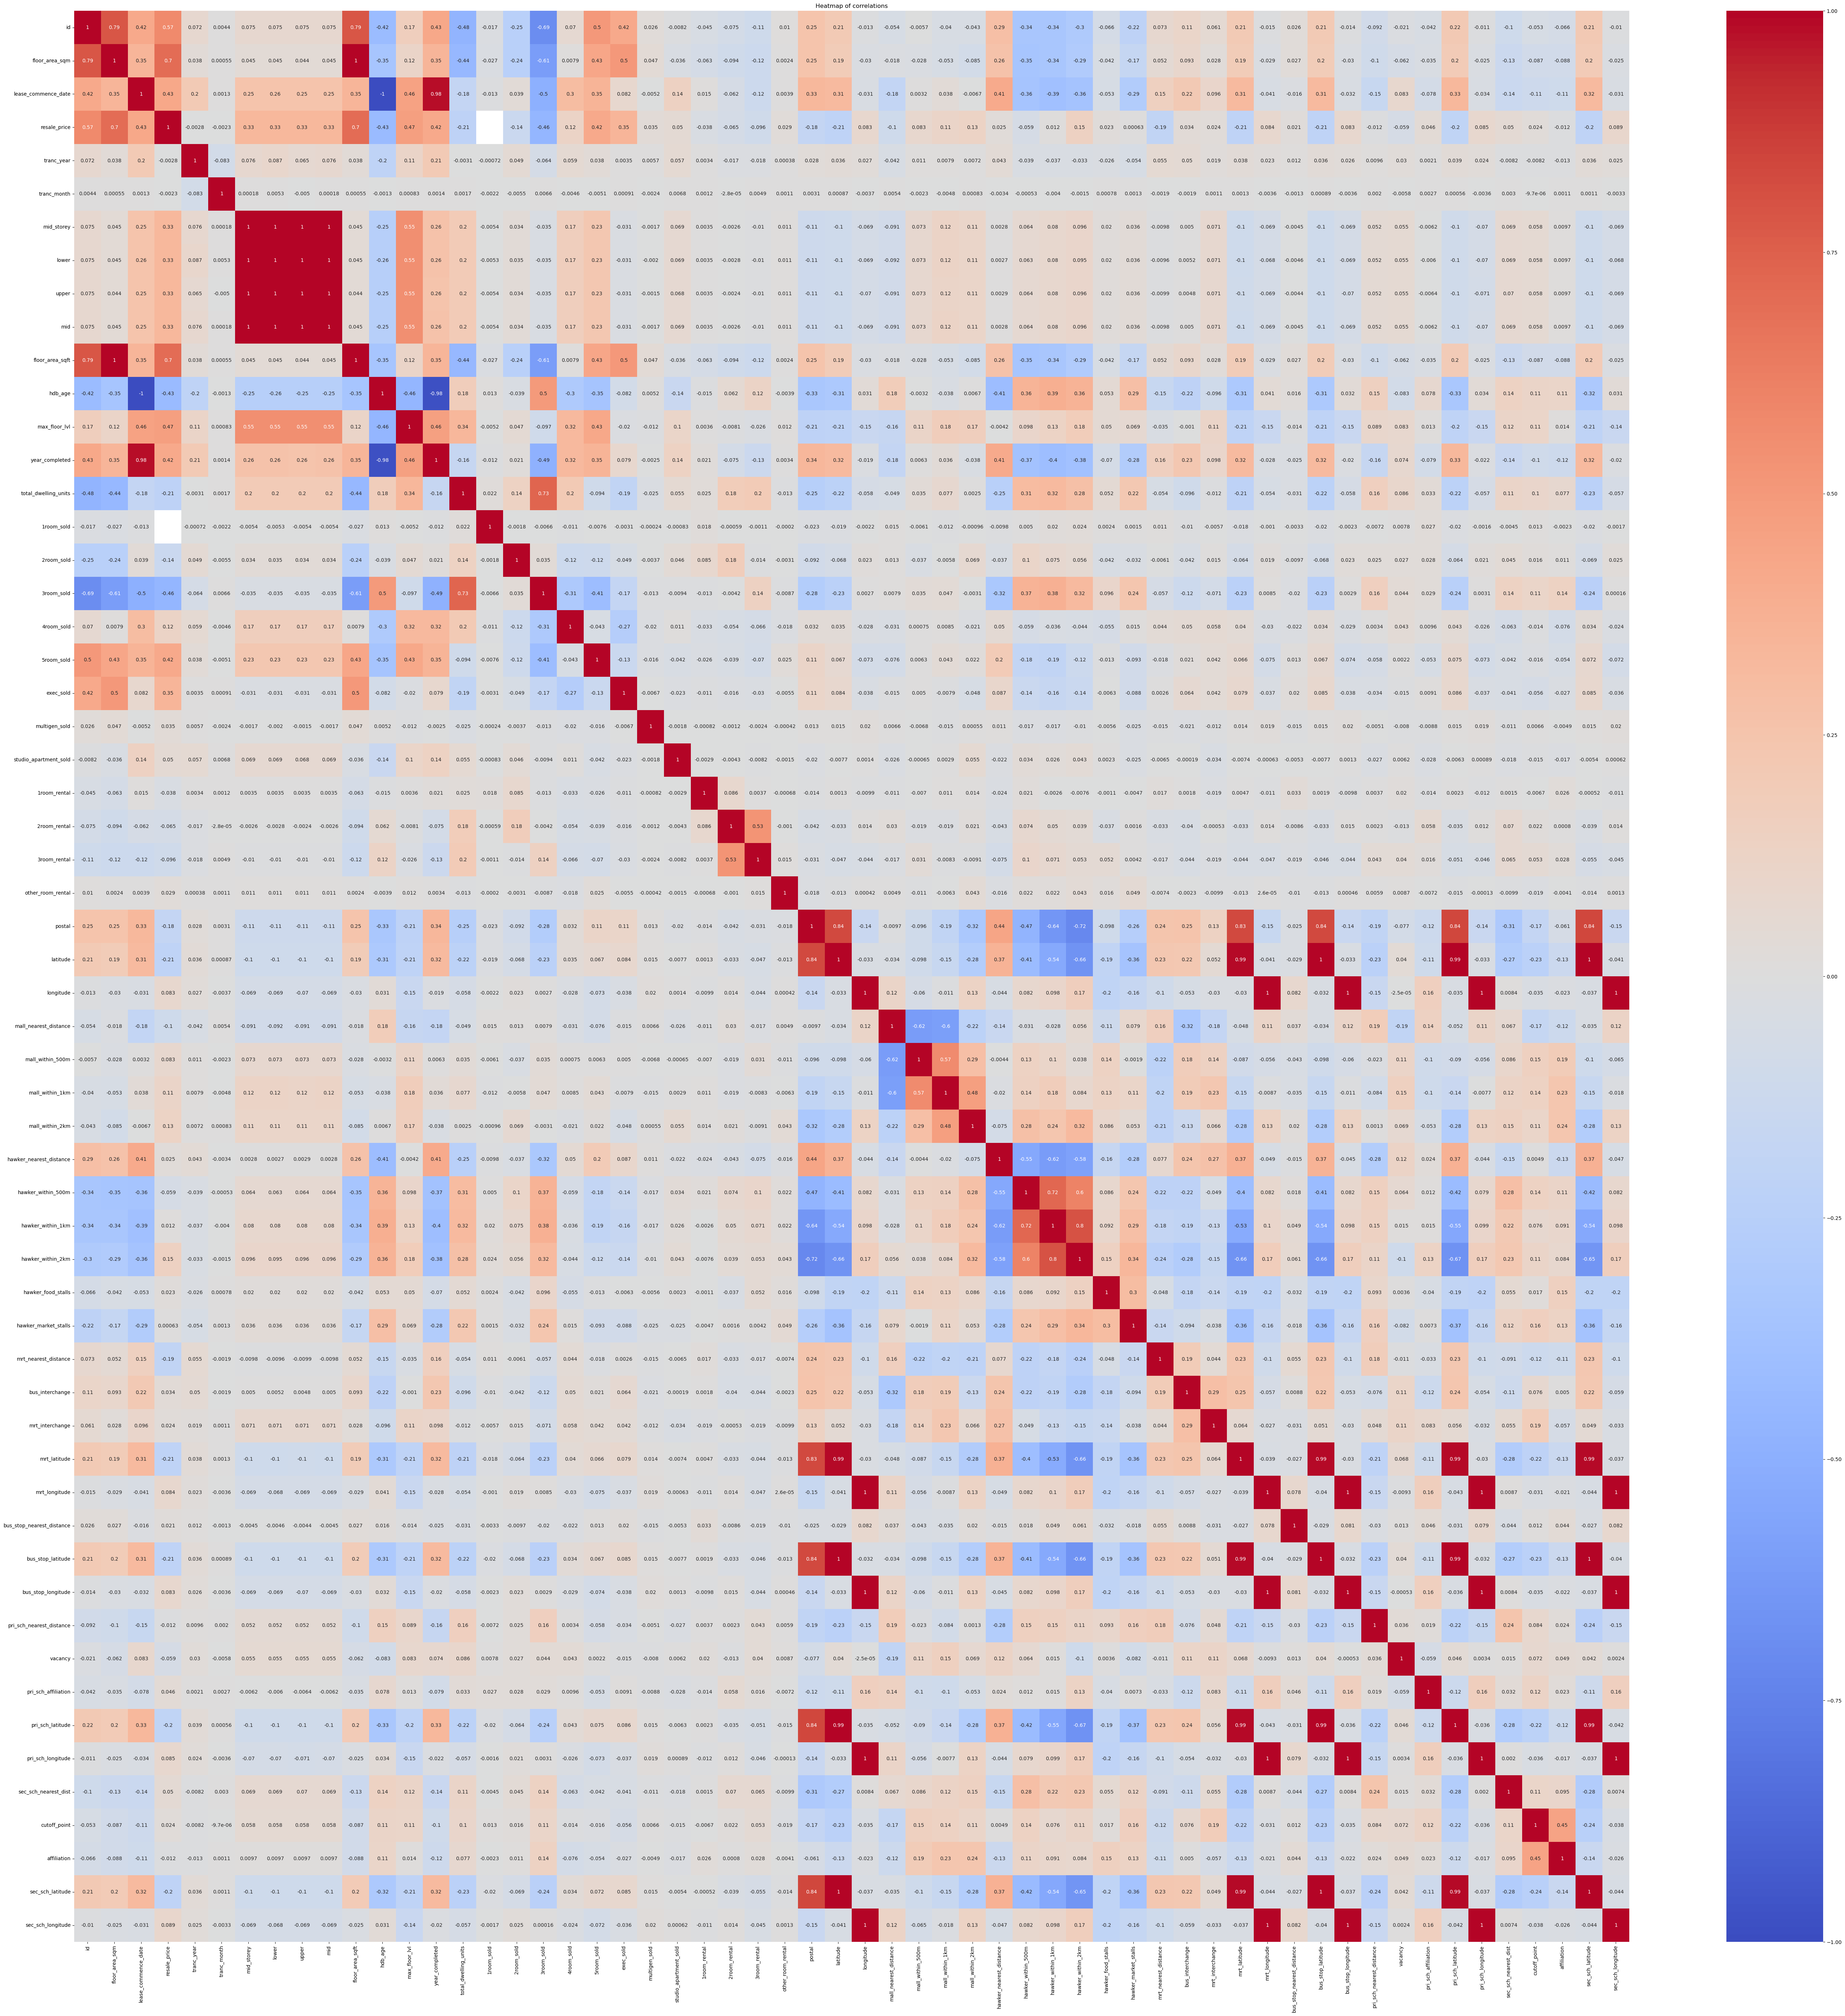

In [22]:
plt.figure(figsize=(70,70))
sns.heatmap(train_data.corr(numeric_only=True), annot=True, cmap='coolwarm')

plt.title("Heatmap of correlations")

plt.show()

In [23]:
# Create feature hdb_age_transaction which shows the age of the hdb at point of transaction
train_data["hdb_age_transaction"] = train_data["tranc_year"] - train_data["lease_commence_date"]

Engineered for age of HDB unit at point of transaction.

In [24]:
train_data['has_rental'] = (train_data[['1room_rental', '2room_rental', '3room_rental', 'other_room_rental']].sum(axis=1) > 0).astype(int) 

Engineer feature to indicate if the unit block contains rental units. While the data offers exact details on how many rental units are present, publicly available data does not show the exact number of units. 

In [25]:
train_data.groupby('has_rental').size()

has_rental
0    58742
1     3326
dtype: int64

In [26]:
train_data['units_per_floor'] = train_data['total_dwelling_units'] / train_data['max_floor_lvl']

Engineered to estimate the number of units present in each floor, as a rough possible indicator of the density of the block which could affect other features such as privacy.

In [27]:
# conditions = [
#     train_data['pri_sch_nearest_distance'] < 1000,
#     (train_data['pri_sch_nearest_distance'] >= 1000) & (train_data['pri_sch_nearest_distance'] < 2000),
#     train_data['pri_sch_nearest_distance'] >= 2000
# ]

# values = [1, 2, 0]

# train_data['pri_sch_dist_radius'] = np.select(conditions, values, default=0)

# Explored with categorising whether unit has primary school within radius 1 and 2km. Did not include into final evaluation as it was very skewed and not meaningful
# Most HDBs are within 2km

In [28]:
# train_data.groupby('pri_sch_dist_radius').size()

The below sections explore the availability of the various `town`, `flat_type` and `flat_model` and their combinations, to check if any combination has very little representation or are likely to pose outliers.

In [29]:
train_data.groupby('flat_type').size()

flat_type
1 ROOM                  7
2 ROOM               1017
3 ROOM              19730
4 ROOM              23136
5 ROOM              13599
EXECUTIVE            4552
MULTI-GENERATION       27
dtype: int64

In [30]:
train_data.groupby(['flat_type','flat_model']).size()

flat_type         flat_model            
1 ROOM            Improved                      7
2 ROOM            2-room                        1
                  Improved                    244
                  Model A                     316
                  Premium Apartment            45
                  Standard                    411
3 ROOM            DBSS                         92
                  Improved                   6268
                  Model A                    3443
                  New Generation             6940
                  Premium Apartment            81
                  Simplified                  715
                  Standard                   2104
                  Terrace                      87
4 ROOM            Adjoined flat                22
                  DBSS                        201
                  Improved                   1081
                  Model A                   13758
                  Model A2                    482
         

In [31]:
train_data.groupby(['town','flat_model']).size()

town             flat_model            
ANG MO KIO       Adjoined flat               31
                 Apartment                   22
                 DBSS                        14
                 Improved                   376
                 Maisonette                   7
                 Model A                    327
                 New Generation            2644
                 Standard                    27
BEDOK            Adjoined flat               13
                 Apartment                  149
                 DBSS                         8
                 Improved                  1393
                 Maisonette                  90
                 Model A                    694
                 Model A-Maisonette          48
                 New Generation            2133
                 Premium Apartment           61
                 Simplified                 178
                 Standard                   171
BISHAN           Adjoined flat                2


In [32]:
train_data.groupby(['flat_model','flat_type']).size()

flat_model              flat_type       
2-room                  2 ROOM                  1
Adjoined flat           4 ROOM                 22
                        5 ROOM                 86
                        EXECUTIVE              51
Apartment               EXECUTIVE            2299
DBSS                    3 ROOM                 92
                        4 ROOM                201
                        5 ROOM                322
Improved                1 ROOM                  7
                        2 ROOM                244
                        3 ROOM               6268
                        4 ROOM               1081
                        5 ROOM               9370
Improved-Maisonette     5 ROOM                  2
Maisonette              EXECUTIVE            1779
Model A                 2 ROOM                316
                        3 ROOM               3443
                        4 ROOM              13758
                        5 ROOM               1033
Model A-M

In [33]:
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='flat_type', y='resale_price', hue='flat_model', data=train_data[(train_data['flat_type'] == "3 ROOM") & train_data['source'] == "Train"])
# plt.title('Boxplot of Resale Price for 3 ROOM Flats')
# plt.show()

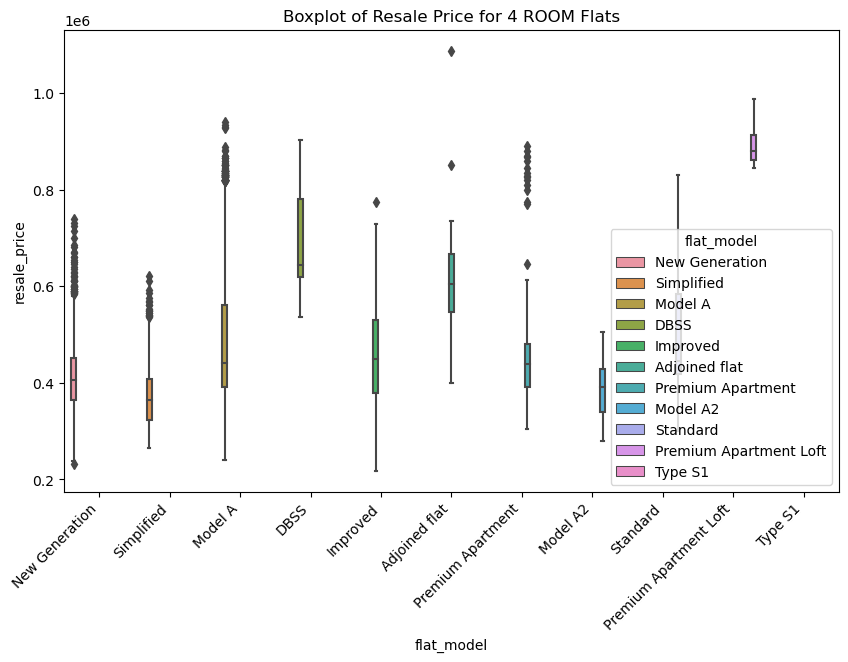

In [34]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='flat_model', y='resale_price', hue='flat_model', data=train_data[train_data['flat_type'] == "4 ROOM"])
plt.title('Boxplot of Resale Price for 4 ROOM Flats')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

Visualising the different models

In [35]:
types_to_drop = ['1 ROOM', 'MULTI-GENERATION']
models_to_drop = ['2-room', 'Terrace', 'Adjoined flat']

train_data = train_data[~train_data['flat_type'].isin(types_to_drop)]
train_data = train_data[~train_data['flat_model'].isin(models_to_drop)]


Based on EDA and our problem statement, we want to cater to a more general crowd for HDB resale units, and omit the above as they are either too few in data, or less generalisable due to vastly different and unique HDB features.

In [36]:
town_region_mapping = {'SEMBAWANG': 'NORTH',
                  'WOODLANDS': 'NORTH',
                  'YISHUN': 'NORTH',
                  'ANG MO KIO': 'NORTH-EAST MATURE',
                  'HOUGANG': 'NORTH-EAST',
                  'PUNGGOL': 'NORTH-EAST',
                  'SENGKANG': 'NORTH-EAST',
                  'SERANGOON': 'NORTH-EAST MATURE',
                  'BEDOK': 'EAST MATURE',
                  'PASIR RIS': 'EAST MATURE',
                  'TAMPINES': 'EAST MATURE',
                  'BUKIT BATOK': 'WEST',
                  'BUKIT PANJANG': 'WEST',
                  'CHOA CHU KANG': 'WEST',
                  'CLEMENTI': 'WEST MATURE',
                  'JURONG EAST': 'WEST',
                  'JURONG WEST': 'WEST',
                  'TENGAH': 'WEST',
                  'BISHAN': 'CENTRAL MATURE',
                  'BUKIT MERAH': 'CENTRAL MATURE',
                  'BUKIT TIMAH': 'CENTRAL MATURE',
                  'CENTRAL AREA': 'CENTRAL MATURE',
                  'GEYLANG': 'CENTRAL MATURE',
                  'KALLANG/WHAMPOA': 'CENTRAL MATURE',
                  'MARINE PARADE': 'CENTRAL MATURE',
                  'QUEENSTOWN': 'CENTRAL MATURE',
                  'TOA PAYOH': 'CENTRAL MATURE'
                }
train_data['region_maturity'] = np.vectorize(town_region_mapping.get)(train_data['town'])

We opted to use HDB's definition of regions and maturity of estate to reduce the number of categories as too many categories might result in overfitting. Although overfitting scores were not observed when using `town` and `planning_area`, we observed that the coefficients of the linear regression models tended to have very low coefficients for a good portion of `planning area`. URA's planning area is also strategically on a wider basis rather than just HDBs, and we have observed cases where units in Bedok were instead classified as Marine Parade. 

HDB's definition of maturity also explains the supply of the estate and ammenities available, providing a broad indicator of the development of the estate.

In [37]:
train_data.groupby(['region_maturity','flat_type']).size()

region_maturity    flat_type
CENTRAL MATURE     2 ROOM        568
                   3 ROOM       7120
                   4 ROOM       4592
                   5 ROOM       2476
                   EXECUTIVE     369
EAST MATURE        2 ROOM         91
                   3 ROOM       3222
                   4 ROOM       4056
                   5 ROOM       2546
                   EXECUTIVE    1161
NORTH              2 ROOM        126
                   3 ROOM       2069
                   4 ROOM       3823
                   5 ROOM       1912
                   EXECUTIVE     646
NORTH-EAST         2 ROOM         81
                   3 ROOM        538
                   4 ROOM       2510
                   5 ROOM       1546
                   EXECUTIVE     480
NORTH-EAST MATURE  2 ROOM         37
                   3 ROOM       2641
                   4 ROOM       1913
                   5 ROOM        767
                   EXECUTIVE     239
WEST               2 ROOM         96
         

In [38]:
train_data.groupby(['flat_type','flat_model']).size()

flat_type  flat_model            
2 ROOM     Improved                    244
           Model A                     316
           Premium Apartment            45
           Standard                    411
3 ROOM     DBSS                         92
           Improved                   6268
           Model A                    3443
           New Generation             6940
           Premium Apartment            81
           Simplified                  715
           Standard                   2104
4 ROOM     DBSS                        201
           Improved                   1081
           Model A                   13758
           Model A2                    482
           New Generation             4012
           Premium Apartment          1717
           Premium Apartment Loft       16
           Simplified                 1794
           Standard                     24
           Type S1                      29
5 ROOM     DBSS                        322
           Improved 

In [39]:
# train_data['is_maissonette'] = train_data['flat_model'].str.contains('Maisonette').astype(int)

In [40]:
# train_data.groupby('is_maissonette').size()

is_maissonette
0    59845
1     1942
dtype: int64

In [42]:
standard_models = ['Standard', 'New Generation', 'Simplified', 'Model A', 'Model A2', 'Improved', 'Apartment', 'Premium Apartment']
maisonette_models = ['Maisonette', 'Improved-Maisonette', 'Model A-Maisonette', 'Premium Maisonette', 'Premium Apartment Loft']
private_design_models = ['DBSS', 'Type S1', 'Type S2']

conditions = [
    train_data['flat_model'].isin(standard_models),
    train_data['flat_model'].isin(maisonette_models),
    train_data['flat_model'].isin(private_design_models)
]

values = ['Standard', 'Maisonette', 'Private Design']

train_data['model_category'] = np.select(conditions, values, default='Unknown')


Based on box plots of the `flat_model` and domain knowledge, we group the `flat_model` further as we've down with town.

In [43]:
train_data.groupby('model_category').size()

model_category
Maisonette         1960
Private Design      656
Standard          59171
dtype: int64

In [44]:
train_data[train_data['model_category'] == 'Unknown'].head()

Empty DataFrame
Columns: [id, tranc_yearmonth, town, flat_type, block, street_name, storey_range, floor_area_sqm, flat_model, lease_commence_date, resale_price, tranc_year, tranc_month, mid_storey, lower, upper, mid, full_flat_type, address, floor_area_sqft, hdb_age, max_floor_lvl, year_completed, residential, commercial, market_hawker, multistorey_carpark, precinct_pavilion, total_dwelling_units, 1room_sold, 2room_sold, 3room_sold, 4room_sold, 5room_sold, exec_sold, multigen_sold, studio_apartment_sold, 1room_rental, 2room_rental, 3room_rental, other_room_rental, postal, latitude, longitude, planning_area, mall_nearest_distance, mall_within_500m, mall_within_1km, mall_within_2km, hawker_nearest_distance, hawker_within_500m, hawker_within_1km, hawker_within_2km, hawker_food_stalls, hawker_market_stalls, mrt_nearest_distance, mrt_name, bus_interchange, mrt_interchange, mrt_latitude, mrt_longitude, bus_stop_nearest_distance, bus_stop_name, bus_stop_latitude, bus_stop_longitude, pri_sch_nearest_distance, pri_sch_name, vacancy, pri_sch_affiliation, pri_sch_latitude, pri_sch_longitude, sec_sch_nearest_dist, sec_sch_name, cutoff_point, affiliation, sec_sch_latitude, sec_sch_longitude, source, hdb_age_transaction, has_rental, units_per_floor, region_maturity, is_maissonette, model_category]
Index: []

In [45]:
cols_keep = ['source',
             'id',
       #'town',
       'region_maturity',
       'flat_type',
       #'flat_model',
       'model_category',
       #'is_maissonette',
       'resale_price', 'tranc_year',
       'tranc_month',
       'mid_storey', 'floor_area_sqft',
       #'max_floor_lvl', 
       #'commercial', 'multistorey_carpark',
       #'precinct_pavilion',
       #'1room_sold', '2room_sold',
       #'3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       #'studio_apartment_sold', 
       #'total_dwelling_units',
       'units_per_floor',
       'has_rental', 'mall_nearest_distance',
       'mall_within_2km',
       'hawker_nearest_distance', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance',
       'bus_interchange', 'mrt_interchange', 'bus_stop_nearest_distance',
       #'pri_sch_dist_radius',
       'pri_sch_nearest_distance',
       #'vacancy',
       #'pri_sch_affiliation', 'sec_sch_nearest_dist',
       #'cutoff_point', 'affiliation',
       'hdb_age_transaction']

train_data = train_data[cols_keep]
len(cols_keep)

24

Determine all the columns that are kept for processing and modelling. 

Other columns are not kept for reasons such as:
- collinearity indicated by correlation heatmap
- replaced by other features
- 0 coefficients in past runs of Lasso regression
- other similar feature chosen over it

In [47]:
train_data.describe()

id  resale_price    tranc_year   tranc_month    mid_storey  \
count   61787.000000  4.518900e+04  61787.000000  61787.000000  61787.000000   
mean    87442.885817  4.471059e+05   2016.471556      6.563598      8.230291   
std     55430.270536  1.547631e+05      2.747698      3.338839      5.531786   
min       106.000000  1.500000e+05   2012.000000      1.000000      2.000000   
25%     37376.500000  3.300000e+05   2014.000000      4.000000      5.000000   
50%     85477.000000  4.120000e+05   2017.000000      7.000000      8.000000   
75%    135648.500000  5.350000e+05   2019.000000      9.000000     11.000000   
max    185906.000000  1.205000e+06   2021.000000     12.000000     50.000000   

       floor_area_sqft  units_per_floor    has_rental  mall_nearest_distance  \
count     61787.000000     61787.000000  61787.000000           61787.000000   
mean       1019.148872         9.245075      0.053312             721.563241   
std         272.544188         4.616268      0.224657             383.625337   
min         365.976000         1.000000      0.000000               0.000000   
25%         742.716000         5.769231      0.000000             422.613062   
50%        1001.052000         8.307692      0.000000             682.018479   
75%        1194.804000        11.125000      0.000000             942.558819   
max        2615.652000        45.363636      1.000000            3496.402910   

       mall_within_2km  hawker_nearest_distance  hawker_within_2km  \
count     61787.000000             61787.000000       61787.000000   
mean          5.394937               909.813186           4.707204   
std           4.421978               853.303354           4.166446   
min           0.000000                 1.873295           0.000000   
25%           3.000000               317.964037           1.000000   
50%           4.000000               608.674879           3.000000   
75%           6.000000              1173.996610           8.000000   
max          43.000000              4816.062542          19.000000   

       hawker_food_stalls  hawker_market_stalls  mrt_nearest_distance  \
count        61787.000000          61787.000000          61787.000000   
mean            51.085050             68.958001            764.413774   
std             21.749461             57.397332            411.701445   
min              0.000000              0.000000             21.971410   
25%             40.000000              0.000000            460.129425   
50%             45.000000             74.000000            703.811065   
75%             60.000000            108.000000            990.232702   
max            226.000000            477.000000           3544.504228   

       bus_interchange  mrt_interchange  bus_stop_nearest_distance  \
count     61787.000000     61787.000000               61787.000000   
mean          0.472915         0.222960                 116.781001   
std           0.499270         0.416235                  56.693269   
min           0.000000         0.000000                   9.001285   
25%           0.000000         0.000000                  75.450198   
50%           0.000000         0.000000                 109.286326   
75%           1.000000         0.000000                 149.821842   
max           1.000000         1.000000                 443.964584   

       pri_sch_nearest_distance  hdb_age_transaction  
count              61787.000000         61787.000000  
mean                 593.919476            26.320974  
std                  256.972880            12.320370  
min                   45.668324             1.000000  
25%                  479.490739            17.000000  
50%                  563.150414            28.000000  
75%                  694.860308            36.000000  
max                 3305.841039            54.000000

In [48]:
train_data.shape

(61787, 24)

In [50]:
len(train_data.columns)

24

### Data Modelling

In [51]:
dummies_cols = ['tranc_month',
                #'town',
                'region_maturity',
                #'is_maissonette',
                #'postal_district',
                'flat_type', 
                'model_category'
                #'pri_sch_dist_radius'
                #'flat_model'
                #, 'commercial', 'multistorey_carpark', 'precinct_pavilion'
                ]
# need to put affliation
#'mrt_name', 'bus_stop_name', 'pri_sch_name', 'sec_sch_name'
train_data_dummies = train_data.copy()

for col in dummies_cols:
    train_data_dummies = pd.get_dummies(train_data_dummies, columns=[col], prefix=col, drop_first=True)

train_data_dummies.columns

# Need to drop first

Index(['source', 'id', 'resale_price', 'tranc_year', 'mid_storey',
       'floor_area_sqft', 'units_per_floor', 'has_rental',
       'mall_nearest_distance', 'mall_within_2km', 'hawker_nearest_distance',
       'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls',
       'mrt_nearest_distance', 'bus_interchange', 'mrt_interchange',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance',
       'hdb_age_transaction', 'tranc_month_2', 'tranc_month_3',
       'tranc_month_4', 'tranc_month_5', 'tranc_month_6', 'tranc_month_7',
       'tranc_month_8', 'tranc_month_9', 'tranc_month_10', 'tranc_month_11',
       'tranc_month_12', 'region_maturity_EAST MATURE',
       'region_maturity_NORTH', 'region_maturity_NORTH-EAST',
       'region_maturity_NORTH-EAST MATURE', 'region_maturity_WEST',
       'region_maturity_WEST MATURE', 'flat_type_3 ROOM', 'flat_type_4 ROOM',
       'flat_type_5 ROOM', 'flat_type_EXECUTIVE',
       'model_category_Private Design', 'model_category_Sta

In [52]:
month_cols = [col for col in train_data_dummies.columns if '_month_' in col]
month_cols

['tranc_month_2',
 'tranc_month_3',
 'tranc_month_4',
 'tranc_month_5',
 'tranc_month_6',
 'tranc_month_7',
 'tranc_month_8',
 'tranc_month_9',
 'tranc_month_10',
 'tranc_month_11',
 'tranc_month_12']

Dummify categorical columns that are not already integer 1/0 based columns

In [53]:
train_data_dummies.dtypes

source                                object
id                                     int64
resale_price                         float64
tranc_year                             int64
mid_storey                             int64
floor_area_sqft                      float64
units_per_floor                      float64
has_rental                             int32
mall_nearest_distance                float64
mall_within_2km                      float64
hawker_nearest_distance              float64
hawker_within_2km                    float64
hawker_food_stalls                     int64
hawker_market_stalls                   int64
mrt_nearest_distance                 float64
bus_interchange                        int64
mrt_interchange                        int64
bus_stop_nearest_distance            float64
pri_sch_nearest_distance             float64
hdb_age_transaction                    int64
tranc_month_2                           bool
tranc_month_3                           bool
tranc_mont

In [54]:
train_data_dummies.describe()

id  resale_price    tranc_year    mid_storey  \
count   61787.000000  4.518900e+04  61787.000000  61787.000000   
mean    87442.885817  4.471059e+05   2016.471556      8.230291   
std     55430.270536  1.547631e+05      2.747698      5.531786   
min       106.000000  1.500000e+05   2012.000000      2.000000   
25%     37376.500000  3.300000e+05   2014.000000      5.000000   
50%     85477.000000  4.120000e+05   2017.000000      8.000000   
75%    135648.500000  5.350000e+05   2019.000000     11.000000   
max    185906.000000  1.205000e+06   2021.000000     50.000000   

       floor_area_sqft  units_per_floor    has_rental  mall_nearest_distance  \
count     61787.000000     61787.000000  61787.000000           61787.000000   
mean       1019.148872         9.245075      0.053312             721.563241   
std         272.544188         4.616268      0.224657             383.625337   
min         365.976000         1.000000      0.000000               0.000000   
25%         742.716000         5.769231      0.000000             422.613062   
50%        1001.052000         8.307692      0.000000             682.018479   
75%        1194.804000        11.125000      0.000000             942.558819   
max        2615.652000        45.363636      1.000000            3496.402910   

       mall_within_2km  hawker_nearest_distance  hawker_within_2km  \
count     61787.000000             61787.000000       61787.000000   
mean          5.394937               909.813186           4.707204   
std           4.421978               853.303354           4.166446   
min           0.000000                 1.873295           0.000000   
25%           3.000000               317.964037           1.000000   
50%           4.000000               608.674879           3.000000   
75%           6.000000              1173.996610           8.000000   
max          43.000000              4816.062542          19.000000   

       hawker_food_stalls  hawker_market_stalls  mrt_nearest_distance  \
count        61787.000000          61787.000000          61787.000000   
mean            51.085050             68.958001            764.413774   
std             21.749461             57.397332            411.701445   
min              0.000000              0.000000             21.971410   
25%             40.000000              0.000000            460.129425   
50%             45.000000             74.000000            703.811065   
75%             60.000000            108.000000            990.232702   
max            226.000000            477.000000           3544.504228   

       bus_interchange  mrt_interchange  bus_stop_nearest_distance  \
count     61787.000000     61787.000000               61787.000000   
mean          0.472915         0.222960                 116.781001   
std           0.499270         0.416235                  56.693269   
min           0.000000         0.000000                   9.001285   
25%           0.000000         0.000000                  75.450198   
50%           0.000000         0.000000                 109.286326   
75%           1.000000         0.000000                 149.821842   
max           1.000000         1.000000                 443.964584   

       pri_sch_nearest_distance  hdb_age_transaction  
count              61787.000000         61787.000000  
mean                 593.919476            26.320974  
std                  256.972880            12.320370  
min                   45.668324             1.000000  
25%                  479.490739            17.000000  
50%                  563.150414            28.000000  
75%                  694.860308            36.000000  
max                 3305.841039            54.000000

In [55]:
train_data_dummies.head()

source     id  resale_price  tranc_year  mid_storey  floor_area_sqft  \
0  Train  21172      280000.0        2015           5          710.424   
1  Train  21179      275000.0        2014           2          710.424   
2  Train  21178      301000.0        2013           5          710.424   
3  Train  21174      280000.0        2019           5          710.424   
4  Train  21175      280000.0        2020           5          710.424   

   units_per_floor  has_rental  mall_nearest_distance  mall_within_2km  \
0              9.0           1             3496.40291              0.0   
1              9.0           1             3496.40291              0.0   
2              9.0           1             3496.40291              0.0   
3              9.0           1             3496.40291              0.0   
4              9.0           1             3496.40291              0.0   

   hawker_nearest_distance  hawker_within_2km  hawker_food_stalls  \
0                105.65314                1.0                  87   
1                105.65314                1.0                  87   
2                105.65314                1.0                  87   
3                105.65314                1.0                  87   
4                105.65314                1.0                  87   

   hawker_market_stalls  mrt_nearest_distance  bus_interchange  \
0                    50           3544.504228                0   
1                    50           3544.504228                0   
2                    50           3544.504228                0   
3                    50           3544.504228                0   
4                    50           3544.504228                0   

   mrt_interchange  bus_stop_nearest_distance  pri_sch_nearest_distance  \
0                0                  21.737868               3305.841039   
1                0                  21.737868               3305.841039   
2                0                  21.737868               3305.841039   
3                0                  21.737868               3305.841039   
4                0                  21.737868               3305.841039   

   hdb_age_transaction  tranc_month_2  tranc_month_3  tranc_month_4  \
0                   35           True          False          False   
1                   34           True          False          False   
2                   33          False          False          False   
3                   39          False          False          False   
4                   40          False          False          False   

   tranc_month_5  tranc_month_6  tranc_month_7  tranc_month_8  tranc_month_9  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False           True          False   
4          False          False          False          False          False   

   tranc_month_10  tranc_month_11  tranc_month_12  \
0           False           False           False   
1           False           False           False   
2           False           False            True   
3           False           False           False   
4           False            True           False   

   region_maturity_EAST MATURE  region_maturity_NORTH  \
0                         True                  False   
1                         True                  False   
2                         True                  False   
3                         True                  False   
4                         True                  False   

   region_maturity_NORTH-EAST  region_maturity_NORTH-EAST MATURE  \
0                       False                              False   
1                       False                              False   
2                       False                              False   
3      

In [56]:
train_data_dummies.shape

(61787, 43)

In [59]:
categorical_cols = dummies_cols + ['mrt_interchange', 'bus_interchange']

non_continuous_cols = [col for col in train_data_dummies.columns if any(col.startswith(prefix) for prefix in categorical_cols)] + ['has_rental']
non_continuous_cols

['bus_interchange',
 'mrt_interchange',
 'tranc_month_2',
 'tranc_month_3',
 'tranc_month_4',
 'tranc_month_5',
 'tranc_month_6',
 'tranc_month_7',
 'tranc_month_8',
 'tranc_month_9',
 'tranc_month_10',
 'tranc_month_11',
 'tranc_month_12',
 'region_maturity_EAST MATURE',
 'region_maturity_NORTH',
 'region_maturity_NORTH-EAST',
 'region_maturity_NORTH-EAST MATURE',
 'region_maturity_WEST',
 'region_maturity_WEST MATURE',
 'flat_type_3 ROOM',
 'flat_type_4 ROOM',
 'flat_type_5 ROOM',
 'flat_type_EXECUTIVE',
 'model_category_Private Design',
 'model_category_Standard',
 'has_rental']

Create variables to list different types of columns that are features for the model

In [60]:
test_data_dummies = train_data_dummies[train_data_dummies['source'] == 'Test']
train_data_dummies = train_data_dummies[train_data_dummies['source'] == 'Train']
train_data_dummies.drop(columns='source', inplace=True)

Split the train.csv and test.csv data prior to modelling

In [61]:
test_data_dummies.reset_index(inplace=True)
test_data_dummies.head()

index source      id  resale_price  tranc_year  mid_storey  \
0  45711   Test  114982           NaN        2012           8   
1  45712   Test   95653           NaN        2019           5   
2  45713   Test   40303           NaN        2013           8   
3  45714   Test  109506           NaN        2017           2   
4  45715   Test  100149           NaN        2016          17   

   floor_area_sqft  units_per_floor  has_rental  mall_nearest_distance  \
0          904.176        11.000000           0             877.431572   
1         1205.568         3.785714           0             534.037705   
2          731.952        18.166667           1             817.050453   
3         1044.108         7.428571           0            1272.737194   
4         1108.692         5.760000           0            1070.963675   

   mall_within_2km  hawker_nearest_distance  hawker_within_2km  \
0              4.0               687.576779                1.0   
1              3.0              2122.346226                0.0   
2              3.0               152.287621               11.0   
3              3.0               501.892158                2.0   
4              5.0               437.593564                2.0   

   hawker_food_stalls  hawker_market_stalls  mrt_nearest_distance  \
0                  56                   123            686.660434   
1                  72                    94            169.478175   
2                  50                   100            694.220448   
3                  52                   112           1117.203587   
4                  60                    87            987.976010   

   bus_interchange  mrt_interchange  bus_stop_nearest_distance  \
0                0                0                  75.683952   
1                0                0                  88.993058   
2                1                0                  86.303575   
3                0                0                 108.459039   
4                0                0                 113.645431   

   pri_sch_nearest_distance  hdb_age_transaction  tranc_month_2  \
0                426.467910                   25          False   
1                439.756851                   11          False   
2                355.882207                   33          False   
3                929.744711                   38          False   
4                309.926934                   31          False   

   tranc_month_3  tranc_month_4  tranc_month_5  tranc_month_6  tranc_month_7  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False          False          False   
4          False          False          False          False          False   

   tranc_month_8  tranc_month_9  tranc_month_10  tranc_month_11  \
0          False          False           False            True   
1           True          False           False           False   
2          False          False            True           False   
3          False          False            True           False   
4           True          False           False           False   

   tranc_month_12  region_maturity_EAST MATURE  region_maturity_NORTH  \
0           False                        False                   True   
1           False                        False                  False   
2           False                        False                  False   
3           False                        False                   True   
4           False                        False                  False   

   region_maturity_NORTH-EAST  region_maturity_NORTH-EAST MATURE  \
0                       False                              False   
1                       False                              False   
2                       Fals

In [62]:
test_dummies_ids = test_data_dummies[['id']].copy()
test_dummies_ids

id
0      114982
1       95653
2       40303
3      109506
4      100149
...       ...
16593   23347
16594   54003
16595  128921
16596   69352
16597  146210

[16598 rows x 1 columns]

Make a copy of the remaining test.csv data, required to create the kaggle submission.

In [63]:
test_predict_data = test_data_dummies.iloc[:,4:]
test_predict_data.head()

tranc_year  mid_storey  floor_area_sqft  units_per_floor  has_rental  \
0        2012           8          904.176        11.000000           0   
1        2019           5         1205.568         3.785714           0   
2        2013           8          731.952        18.166667           1   
3        2017           2         1044.108         7.428571           0   
4        2016          17         1108.692         5.760000           0   

   mall_nearest_distance  mall_within_2km  hawker_nearest_distance  \
0             877.431572              4.0               687.576779   
1             534.037705              3.0              2122.346226   
2             817.050453              3.0               152.287621   
3            1272.737194              3.0               501.892158   
4            1070.963675              5.0               437.593564   

   hawker_within_2km  hawker_food_stalls  hawker_market_stalls  \
0                1.0                  56                   123   
1                0.0                  72                    94   
2               11.0                  50                   100   
3                2.0                  52                   112   
4                2.0                  60                    87   

   mrt_nearest_distance  bus_interchange  mrt_interchange  \
0            686.660434                0                0   
1            169.478175                0                0   
2            694.220448                1                0   
3           1117.203587                0                0   
4            987.976010                0                0   

   bus_stop_nearest_distance  pri_sch_nearest_distance  hdb_age_transaction  \
0                  75.683952                426.467910                   25   
1                  88.993058                439.756851                   11   
2                  86.303575                355.882207                   33   
3                 108.459039                929.744711                   38   
4                 113.645431                309.926934                   31   

   tranc_month_2  tranc_month_3  tranc_month_4  tranc_month_5  tranc_month_6  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False          False          False   
4          False          False          False          False          False   

   tranc_month_7  tranc_month_8  tranc_month_9  tranc_month_10  \
0          False          False          False           False   
1          False           True          False           False   
2          False          False          False            True   
3          False          False          False            True   
4          False           True          False           False   

   tranc_month_11  tranc_month_12  region_maturity_EAST MATURE  \
0            True           False                        False   
1           False           False                        False   
2           False           False                        False   
3           False           False                        False   
4           False           False                        False   

   region_maturity_NORTH  region_maturity_NORTH-EAST  \
0                   True                       False   
1                  False                       False   
2                  False                       False   
3                   True                       False   
4                  False                       False   

   region_maturity_NORTH-EAST MATURE  region_maturity_WEST  \
0                              False                 False   
1                              False                  True   
2                               True                 False   
3                              F

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    #train_numeric,
    train_data_dummies.iloc[:, 2:],
    train_data_dummies['resale_price'],
    test_size=0.2, #0.7
    random_state=42
)

In [65]:
train_data_dummies.iloc[:, 2:]

tranc_year  mid_storey  floor_area_sqft  units_per_floor  has_rental  \
0            2015           5          710.424         9.000000           1   
1            2014           2          710.424         9.000000           1   
2            2013           5          710.424         9.000000           1   
3            2019           5          710.424         9.000000           1   
4            2020           5          710.424         9.000000           1   
...           ...         ...              ...              ...         ...   
45706        2013           2         1205.568         5.705882           0   
45707        2016           8          731.952        19.818182           0   
45708        2020          20          635.076        19.818182           0   
45709        2012           3          635.076        19.818182           0   
45710        2014           5          635.076        19.818182           0   

       mall_nearest_distance  mall_within_2km  hawker_nearest_distance  \
0                3496.402910              0.0               105.653140   
1                3496.402910              0.0               105.653140   
2                3496.402910              0.0               105.653140   
3                3496.402910              0.0               105.653140   
4                3496.402910              0.0               105.653140   
...                      ...              ...                      ...   
45706             182.511923              5.0               186.281946   
45707             188.745077              5.0               262.355562   
45708             188.745077              5.0               262.355562   
45709             188.745077              5.0               262.355562   
45710             188.745077              5.0               262.355562   

       hawker_within_2km  hawker_food_stalls  hawker_market_stalls  \
0                    1.0                  87                    50   
1                    1.0                  87                    50   
2                    1.0                  87                    50   
3                    1.0                  87                    50   
4                    1.0                  87                    50   
...                  ...                 ...                   ...   
45706                8.0                  82                   114   
45707                3.0                  72                    94   
45708                3.0                  72                    94   
45709                3.0                  72                    94   
45710                3.0                  72                    94   

       mrt_nearest_distance  bus_interchange  mrt_interchange  \
0               3544.504228                0                0   
1               3544.504228                0                0   
2               3544.504228                0                0   
3               3544.504228                0                0   
4               3544.504228                0                0   
...                     ...              ...              ...   
45706            565.976852                1                0   
45707           1026.342759                1                0   
45708           1026.342759                1                0   
45709           1026.342759                1                0   
45710           1026.342759                1                0   

       bus_stop_nearest_distance  pri_sch_nearest_distance  \
0                      21.737868               3305.841039   
1                      21.737868               3305.841039   
2                      21.737868               3305.841039   
3                      21.737868               3305.841039   
4                      21.737868               3305.841039   
...                          ...                       ...   
45706                 131.662513                464.970274   
45707                 101.895861                464

In [66]:
type(X_test)

pandas.core.frame.DataFrame

In [67]:
continuous_cols = list(train_data_dummies.columns.difference(non_continuous_cols))
columns_to_remove = ['id', 'resale_price']

continuous_cols = [col for col in continuous_cols if col not in columns_to_remove]
continuous_cols

['bus_stop_nearest_distance',
 'floor_area_sqft',
 'hawker_food_stalls',
 'hawker_market_stalls',
 'hawker_nearest_distance',
 'hawker_within_2km',
 'hdb_age_transaction',
 'mall_nearest_distance',
 'mall_within_2km',
 'mid_storey',
 'mrt_nearest_distance',
 'pri_sch_nearest_distance',
 'tranc_year',
 'units_per_floor']

Define the continuous columns that need to be scaled.

In [68]:
Z_train = X_train
Z_test = X_test

sc = StandardScaler()
Z_train[continuous_cols] = sc.fit_transform(X_train[continuous_cols])
Z_test[continuous_cols] = sc.transform(X_test[continuous_cols])

Z_train[non_continuous_cols] = X_train[non_continuous_cols]
Z_test[non_continuous_cols] = X_test[non_continuous_cols]

Scale X

In [69]:
print(f'Z_train shape is: {Z_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'Z_test shape is: {Z_test.shape}')
print(f'y_test shape is: {y_test.shape}')

Z_train shape is: (36151, 40)
y_train shape is: (36151,)
Z_test shape is: (9038, 40)
y_test shape is: (9038,)


In [70]:
Z_train_ols = sm.add_constant(Z_train)
model_sm = sm.OLS(y_train.astype(float), Z_train_ols.astype(float)).fit()

In [71]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     5364.
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:03:40   Log-Likelihood:            -4.4831e+05
No. Observations:               36151   AIC:                         8.967e+05
Df Residuals:                   36110   BIC:                         8.970e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                              4.821e+05   4005.545    120.370      0.000    4.74e+05     4.9e+05
tranc_year                        -4933.6989    323.002    -15.275      0.000   -5566.792   -4300.606
mid_storey                         2.385e+04    337.316     70.717      0.000    2.32e+04    2.45e+04
floor_area_sqft                    8.111e+04   1119.157     72.473      0.000    7.89e+04    8.33e+04
units_per_floor                   -8100.1221    423.662    -19.119      0.000   -8930.513   -7269.731
has_rental                         4225.4793   1466.794      2.881      0.004    1350.520    7100.439
mall_nearest_distance             -4464.8948    380.958    -11.720      0.000   -5211.583   -3718.207
mall_within_2km                   -1570.5955    363.200     -4.324      0.000   -2282.479    -858.712
hawker_nearest_distance           -1.453e+04    445.481    -32.610      0.000   -1.54e+04   -1.37e+04
hawker_within_2km                  1.368e+04    647.277     21.135      0.000    1.24e+04    1.49e+04
hawker_food_stalls                -2474.1085    356.862     -6.933      0.000   -3173.569   -1774.648
hawker_market_stalls               1.048e+04    368.296     28.456      0.000    9758.479    1.12e+04
mrt_nearest_distance              -2.266e+04    378.752    -59.827      0.000   -2.34e+04   -2.19e+04
bus_interchange                    6880.9660    811.485      8.479      0.000    5290.432    8471.500
mrt_interchange                    9470.2035    860.121     11.010      0.000    7784.341    1.12e+04
bus_stop_nearest_distance          -157.5629    315.883     -0.499      0.618    -776.703     461.578
pri_sch_nearest_distance           8328.0573    359.535     23.163      0.000    7623.358    9032.757
hdb_age_transaction               -5.114e+04    433.195   -118.061      0.000    -5.2e+04   -5.03e+04
tranc_month_2                      1264.8748   1690.131      0.748      0.454   -2047.833    4577.582
tranc_month_3                      -216.9903   1516.414     -0.143      0.886   -3189.206    2755.226
tranc_month_4                      -864.7584   1554.542     -0.556      0.578   -3911.707    2182.191
tranc_month_5                     -7681.3074   1590.264     -4.830      0.000   -1.08e+04   -4564.343
tranc_month_6                     -6989.0528   1562.845     -4.472      0.000   -1.01e+04   -3925.831
tranc_month_7                     -7665.9678   1540.053     -4.978      0.000   -1.07e+04   -4647.419
tranc_month_8                     -7442.9212   1556.760     -4.781      0.000   -1.05e+04   -4391.625
tranc_month_9                     -7128.8209   1571.701     -4.536      0.000   -1.02e+04   -4048.239
tranc_month_10                    -6359.2626   1554.393     -4.091      0.000   -9405.919   -3312.606
tranc_month_11         

In [72]:
ols = LinearRegression()


In [73]:
lr_scores = cross_val_score(ols, Z_train, y_train, cv=5)
lr_scores.mean()

0.8555641822987013

In [74]:
ols.fit(Z_train, y_train)

LinearRegression()

In [75]:
# How does the model score on the training and test data?
print(ols.score(Z_train, y_train))
print(ols.score(Z_test, y_test))

0.8559545944306972
0.8593005281564801


In [125]:
print(metrics.mean_squared_error(y_test, ols.predict(Z_test))) #MSE
print(metrics.mean_squared_error(y_test, ols.predict(Z_test), squared=False)) #RMSE

3335416125.084355
57753.06160788668


In [76]:
ols.coef_

array([  -4933.69893148,   23853.80092413,   81108.58714276,
         -8100.12212099,    4225.47931773,   -4464.89480941,
         -1570.59547045,  -14527.08069231,   13680.49444485,
         -2474.108457  ,   10480.34977785,  -22659.45227335,
          6880.9659875 ,    9470.20350811,    -157.5628967 ,
          8328.05731819,  -51143.28338839,    1264.87477367,
          -216.99029444,    -864.75839854,   -7681.30735096,
         -6989.05275339,   -7665.96781182,   -7442.92117702,
         -7128.82089199,   -6359.2626239 ,   -4728.70464319,
         -4908.39394975,  -69897.07847301, -135803.0278828 ,
        -90908.64511368,  -32533.01175633, -122203.17321839,
        -17564.41025632,   40317.77927292,   66719.78240498,
         95042.58841273,  127287.15053775,   84248.79387456,
        -37834.87077344])

In [77]:
r_alphas = np.logspace(0, 5, 100)
# np.linspace(.1, 10, 100)

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
#ridge_cv = RidgeCV(scoring='r2', cv=5).fit(Z_train, y_train)


In [78]:
ridge_scores = cross_val_score(ridge_cv, Z_train, y_train, cv=5)
ridge_scores.mean()

0.855563280155088

In [79]:

ridge_cv.fit(Z_train, y_train)
print(ridge_cv.get_params)

<bound method BaseEstimator.get_params of RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5, scoring='r2')>


In [80]:
ridge_cv.alpha_

1.0

In [81]:
print(ridge_cv.score(Z_train, y_train))
print(ridge_cv.score(Z_test, y_test))

0.855953953213978
0.8593208896459894


In [126]:
print(metrics.mean_squared_error(y_test, ridge_cv.predict(Z_test))) #MSE
print(metrics.mean_squared_error(y_test, ridge_cv.predict(Z_test), squared=False)) #RMSE

3334933436.4178624
57748.88255557732


### Evaluation

Ridge regularisation model performs slightly better than linear regression baseline in score and error.

Although Lasso model has better R2 and cross validation score, the Ridge model has the lowest RMSE value, which is relevant to our problem statement by giving the lowest margin of error for the predicted resale price. The Ridge model also still fairs very well in having close test and training scores.

In [82]:
coefficients = list(zip(ridge_cv.coef_, train_data_dummies.iloc[:, 2:].columns))
sorted_coefficients = sorted(coefficients, key=lambda x: abs(x[0]), reverse=True)
for coef, feature in sorted_coefficients:
    print(f"{feature}: {coef}")

region_maturity_NORTH: -135537.5194525498
flat_type_EXECUTIVE: 125594.44137406668
region_maturity_WEST: -121957.19865399964
flat_type_5 ROOM: 93676.52003395969
region_maturity_NORTH-EAST: -90587.79665851632
model_category_Private Design: 84013.29362134142
floor_area_sqft: 81367.73950964556
region_maturity_EAST MATURE: -69718.58666654857
flat_type_4 ROOM: 65605.75300315155
hdb_age_transaction: -51143.638665795035
flat_type_3 ROOM: 39520.948176299746
model_category_Standard: -37910.82405800879
region_maturity_NORTH-EAST MATURE: -32375.290861261026
mid_storey: 23865.945102532183
mrt_nearest_distance: -22678.116121481027
region_maturity_WEST MATURE: -17374.28885932539
hawker_nearest_distance: -14529.98063348855
hawker_within_2km: 13758.964777261632
hawker_market_stalls: 10463.491063288906
mrt_interchange: 9495.829564264097
pri_sch_nearest_distance: 8335.22133161977
units_per_floor: -8111.371508281271
tranc_month_5: -7655.841269979984
tranc_month_7: -7641.830043114508
tranc_month_8: -7415.7

We use the coefficients of the regression model to explain which are the key features that affect the resale price most significantly. We have chosen the Ridge model as we wanted to keep all the features left that we had manually selected other multiple runs of different models and split ratios.

### Kaggle Prediction

The below section predicts and stitches the information back into a .csv file for Kaggle submission.

In [83]:
test_predict_data

tranc_year  mid_storey  floor_area_sqft  units_per_floor  has_rental  \
0            2012           8          904.176        11.000000           0   
1            2019           5         1205.568         3.785714           0   
2            2013           8          731.952        18.166667           1   
3            2017           2         1044.108         7.428571           0   
4            2016          17         1108.692         5.760000           0   
...           ...         ...              ...              ...         ...   
16593        2016           5          882.648        23.454545           0   
16594        2017          17          990.288         5.000000           0   
16595        2018           5         1184.040         7.500000           0   
16596        2020           8          904.176        11.555556           0   
16597        2012           8         1119.456         7.692308           0   

       mall_nearest_distance  mall_within_2km  hawker_nearest_distance  \
0                 877.431572              4.0               687.576779   
1                 534.037705              3.0              2122.346226   
2                 817.050453              3.0               152.287621   
3                1272.737194              3.0               501.892158   
4                1070.963675              5.0               437.593564   
...                      ...              ...                      ...   
16593            1120.535819              2.0               226.144646   
16594             519.046576              5.0              4254.303044   
16595             685.922630              3.0              3917.745229   
16596             846.849200              3.0               773.521588   
16597             859.402513              1.0               846.925250   

       hawker_within_2km  hawker_food_stalls  hawker_market_stalls  \
0                    1.0                  56                   123   
1                    0.0                  72                    94   
2                   11.0                  50                   100   
3                    2.0                  52                   112   
4                    2.0                  60                    87   
...                  ...                 ...                   ...   
16593                8.0                  52                   166   
16594                0.0                  40                     0   
16595                0.0                  28                    45   
16596                7.0                  80                    77   
16597                1.0                 123                    57   

       mrt_nearest_distance  bus_interchange  mrt_interchange  \
0                686.660434                0                0   
1                169.478175                0                0   
2                694.220448                1                0   
3               1117.203587                0                0   
4                987.976010                0                0   
...                     ...              ...              ...   
16593            674.098299                1                0   
16594            452.475847                1                1   
16595            739.510043                0                0   
16596            877.694888                1                1   
16597           1890.577088                0                0   

       bus_stop_nearest_distance  pri_sch_nearest_distance  \
0                      75.683952                426.467910   
1                      88.993058                439.756851   
2                      86.303575                355.882207   
3                     108.459039                929.744711   
4                     113.645431                309.926934   
...                          ...                       ...   
16593                  76.352127                556.368531   
16594                  81.731727                149

In [84]:
Z_predict = test_predict_data
Z_predict[continuous_cols] = sc.transform(test_predict_data[continuous_cols])

Z_predict[non_continuous_cols] = test_predict_data[non_continuous_cols]

In [85]:
Z_predict

tranc_year  mid_storey  floor_area_sqft  units_per_floor  has_rental  \
0       -1.627655   -0.038950        -0.388599         0.338125           0   
1        0.917889   -0.580385         0.702469        -1.173939           0   
2       -1.264005   -0.038950        -1.012067         1.840208           1   
3        0.190591   -1.121820         0.117968        -0.410422           0   
4       -0.173058    1.585354         0.351768        -0.760142           0   
...           ...         ...              ...              ...         ...   
16593   -0.173058   -0.580385        -0.466533         2.948510           0   
16594    0.190591    1.585354        -0.076866        -0.919433           0   
16595    0.554240   -0.580385         0.624535        -0.395451           0   
16596    1.281539   -0.038950        -0.388599         0.454565           0   
16597   -1.627655   -0.038950         0.390735        -0.355144           0   

       mall_nearest_distance  mall_within_2km  hawker_nearest_distance  \
0                   0.343911        -0.310484                -0.173098   
1                  -0.541111        -0.522076                 1.787692   
2                   0.188292        -0.522076                -0.904636   
3                   1.362724        -0.522076                -0.426858   
4                   0.842697        -0.098892                -0.514730   
...                      ...              ...                      ...   
16593               0.970459        -0.733668                -0.803701   
16594              -0.579748        -0.098892                 4.701274   
16595              -0.149661        -0.522076                 4.241326   
16596               0.265091        -0.522076                -0.055643   
16597               0.297445        -0.945259                 0.044672   

       hawker_within_2km  hawker_food_stalls  hawker_market_stalls  \
0              -0.969612            0.171675              0.865709   
1              -1.209975            0.877143              0.364325   
2               1.434022           -0.092876              0.468060   
3              -0.729248           -0.004692              0.675529   
4              -0.729248            0.348042              0.243302   
...                  ...                 ...                   ...   
16593           0.712932           -0.004692              1.609140   
16594          -1.209975           -0.533793             -1.260849   
16595          -1.209975           -1.062895             -0.482840   
16596           0.472569            1.229878              0.070411   
16597          -0.969612            3.125824             -0.275371   

       mrt_nearest_distance  bus_interchange  mrt_interchange  \
0                 -0.190171                0                0   
1                 -1.469474                0                0   
2                 -0.171470                1                0   
3                  0.874822                0                0   
4                  0.555164                0                0   
...                     ...              ...              ...   
16593             -0.221244                1                0   
16594             -0.769450                1                1   
16595             -0.059442                0                0   
16596              0.282373                1                1   
16597              2.787841                0                0   

       bus_stop_nearest_distance  pri_sch_nearest_distance  \
0                      -0.735869                 -1.071314   
1                      -0.502010                 -1.012074   
2                      -0.549268                 -1.385976   
3                      -0.159965                  1.172227   
4                      -0.068833                 -1.590839   
...                          ...                       ...   
16593                  -0.724129                 -0.492235   
16594                  -0.629602                 -2

In [86]:
predictions = ridge_cv.predict(Z_predict)

In [87]:
predictions

array([344110.05273942, 511418.6646757 , 370956.45524735, ...,
       405056.04820364, 444194.5577128 , 380307.1109183 ])

In [88]:
test_dummies_ids.head()

id
0  114982
1   95653
2   40303
3  109506
4  100149

In [89]:
predictions_results = test_dummies_ids
predictions_results['predicted'] = np.round(predictions,-3)

predictions_results.head()

id  predicted
0  114982   344000.0
1   95653   511000.0
2   40303   371000.0
3  109506   297000.0
4  100149   408000.0

In [90]:
predictions_results.describe()

id     predicted
count   16598.000000  1.659800e+04
mean    92222.902398  4.405251e+05
std     53201.121260  1.334425e+05
min       106.000000  4.800000e+04
25%     46596.000000  3.480000e+05
50%     92045.000000  4.290000e+05
75%    137492.250000  5.200000e+05
max    185904.000000  1.067000e+06

In [91]:
predictions_csv = pd.merge(test_ids,predictions_results, on='id', how='left')
predictions_csv.columns = predictions_csv.columns.str.capitalize()
predictions_csv

Id  Predicted
0      114982   344000.0
1       95653   511000.0
2       40303   371000.0
3      109506   297000.0
4      100149   408000.0
...       ...        ...
16732   23347   377000.0
16733   54003   463000.0
16734  128921   405000.0
16735   69352   444000.0
16736  146210   380000.0

[16737 rows x 2 columns]

In [129]:
predictions_csv.fillna(value=0, inplace=True)

We fill the empty predictions with 0 as Kaggle does not allow null predictions. We have omitted to predict these data as part of our problem statement.

In [130]:
predictions_csv.to_csv('../data/prediction.csv', index=False)

### Other Exploration and Graphs

The below section are working codes for Lasso and ElasticNet.

In [93]:
# Set up a list of Lasso alphas to check.
#l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
#lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)
lasso_cv = LassoCV(n_alphas=200, cv=5, max_iter=50000)


lasso_scores = cross_val_score(lasso_cv, Z_train, y_train, cv=5)
lasso_scores.mean()



0.854196754295889

In [94]:
lasso_cv.fit(Z_train, y_train)

LassoCV(cv=5, max_iter=50000, n_alphas=200)

In [95]:
lasso_cv.alpha_

108.11171956984306

In [96]:
print(lasso_cv.score(Z_train, y_train))
print(lasso_cv.score(Z_test, y_test))

0.8545681724596117
0.8585719724351795


In [127]:
print(metrics.mean_squared_error(y_test, lasso_cv.predict(Z_test))) #MSE
print(metrics.mean_squared_error(y_test, lasso_cv.predict(Z_test), squared=False)) #RMSE

3352687238.25208
57902.39406321711


In [97]:
coefficients = list(zip(lasso_cv.coef_, train_data_dummies.iloc[:, 2:].columns))
sorted_coefficients = sorted(coefficients, key=lambda x: abs(x[0]), reverse=True)
for coef, feature in sorted_coefficients:
    print(f"{feature}: {coef}")

region_maturity_NORTH: -124932.8830447065
region_maturity_WEST: -111478.2059533732
floor_area_sqft: 91456.03225674249
region_maturity_NORTH-EAST: -76953.21717150246
model_category_Private Design: 76466.43460431376
region_maturity_EAST MATURE: -61912.5902224629
flat_type_EXECUTIVE: 56141.056601224016
hdb_age_transaction: -51049.685239350394
model_category_Standard: -37529.72546069094
flat_type_5 ROOM: 35229.44277157071
mid_storey: 24302.01069592344
region_maturity_NORTH-EAST MATURE: -23836.60833691219
mrt_nearest_distance: -23414.471006770003
flat_type_4 ROOM: 16834.805270830937
hawker_within_2km: 16748.95864868214
hawker_nearest_distance: -14593.463456485926
mrt_interchange: 10389.979975190747
hawker_market_stalls: 9626.100294202153
pri_sch_nearest_distance: 8539.123461065308
units_per_floor: -8371.666753406158
region_maturity_WEST MATURE: -6242.883404500705
bus_interchange: 4672.039599830412
tranc_year: -4482.458667024508
mall_nearest_distance: -4402.889290858995
tranc_month_2: 4237.4

In [98]:
zeroed_away = [x for x in coefficients if x[0] == 0 ]
print(len(zeroed_away))
zeroed_away

3


[(0.0, 'has_rental'), (-0.0, 'tranc_month_11'), (-0.0, 'tranc_month_12')]

In [99]:
enet = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=200)
enet.fit(Z_train, y_train)

ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], n_alphas=200)

In [100]:
print(enet.alpha_)
print(enet.l1_ratio_)

108.11171956984306
1.0


In [101]:
enet = ElasticNet(alpha=enet.alpha_, l1_ratio=enet.l1_ratio_)

enet_scores = cross_val_score(enet, Z_train, y_train, cv=10)

print (enet_scores)
print (np.mean(enet_scores))

[0.84802173 0.84963377 0.85783239 0.85497831 0.85270795 0.85857455
 0.85254377 0.85303963 0.86142545 0.85285382]
0.8541611353921521


The below section is code to create graphs used for the presentation, and some for curiousity.

In [102]:
hdb_graph_data = train_data[train_data['source'] == 'Train'].drop(columns='source')
hdb_graph_data.head()

id region_maturity flat_type model_category  resale_price  tranc_year  \
0  21172     EAST MATURE    3 ROOM       Standard      280000.0        2015   
1  21179     EAST MATURE    3 ROOM       Standard      275000.0        2014   
2  21178     EAST MATURE    3 ROOM       Standard      301000.0        2013   
3  21174     EAST MATURE    3 ROOM       Standard      280000.0        2019   
4  21175     EAST MATURE    3 ROOM       Standard      280000.0        2020   

   tranc_month  mid_storey  floor_area_sqft  units_per_floor  has_rental  \
0            2           5          710.424              9.0           1   
1            2           2          710.424              9.0           1   
2           12           5          710.424              9.0           1   
3            8           5          710.424              9.0           1   
4           11           5          710.424              9.0           1   

   mall_nearest_distance  mall_within_2km  hawker_nearest_distance  \
0             3496.40291              0.0                105.65314   
1             3496.40291              0.0                105.65314   
2             3496.40291              0.0                105.65314   
3             3496.40291              0.0                105.65314   
4             3496.40291              0.0                105.65314   

   hawker_within_2km  hawker_food_stalls  hawker_market_stalls  \
0                1.0                  87                    50   
1                1.0                  87                    50   
2                1.0                  87                    50   
3                1.0                  87                    50   
4                1.0                  87                    50   

   mrt_nearest_distance  bus_interchange  mrt_interchange  \
0           3544.504228                0                0   
1           3544.504228                0                0   
2           3544.504228                0                0   
3           3544.504228                0                0   
4           3544.504228                0                0   

   bus_stop_nearest_distance  pri_sch_nearest_distance  hdb_age_transaction  
0                  21.737868               3305.841039                   35  
1                  21.737868               3305.841039                   34  
2                  21.737868               3305.841039                   33  
3                  21.737868               3305.841039                   39  
4                  21.737868               3305.841039                   40

In [103]:
hdb_graph_data['psf'] = hdb_graph_data['resale_price'] / hdb_graph_data['floor_area_sqft']

In [104]:
hdb_graph_data.groupby(['tranc_year', 'flat_type']).size()

tranc_year  flat_type
2012        2 ROOM         70
            3 ROOM       1783
            4 ROOM       1688
            5 ROOM        917
            EXECUTIVE     358
2013        2 ROOM         74
            3 ROOM       1584
            4 ROOM       1298
            5 ROOM        819
            EXECUTIVE     265
2014        2 ROOM         57
            3 ROOM       1542
            4 ROOM       1293
            5 ROOM        726
            EXECUTIVE     260
2015        2 ROOM         49
            3 ROOM       1609
            4 ROOM       1524
            5 ROOM        841
            EXECUTIVE     311
2016        2 ROOM         62
            3 ROOM       1632
            4 ROOM       1704
            5 ROOM        969
            EXECUTIVE     304
2017        2 ROOM         68
            3 ROOM       1692
            4 ROOM       1774
            5 ROOM       1077
            EXECUTIVE     380
2018        2 ROOM         95
            3 ROOM       1521
            4 ROOM

C:\Users\user\AppData\Local\Temp\ipykernel_17684\827098924.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='tranc_year', y='psf', hue='flat_type', data=median_psf, marker='o', palette='hls', ci=None)


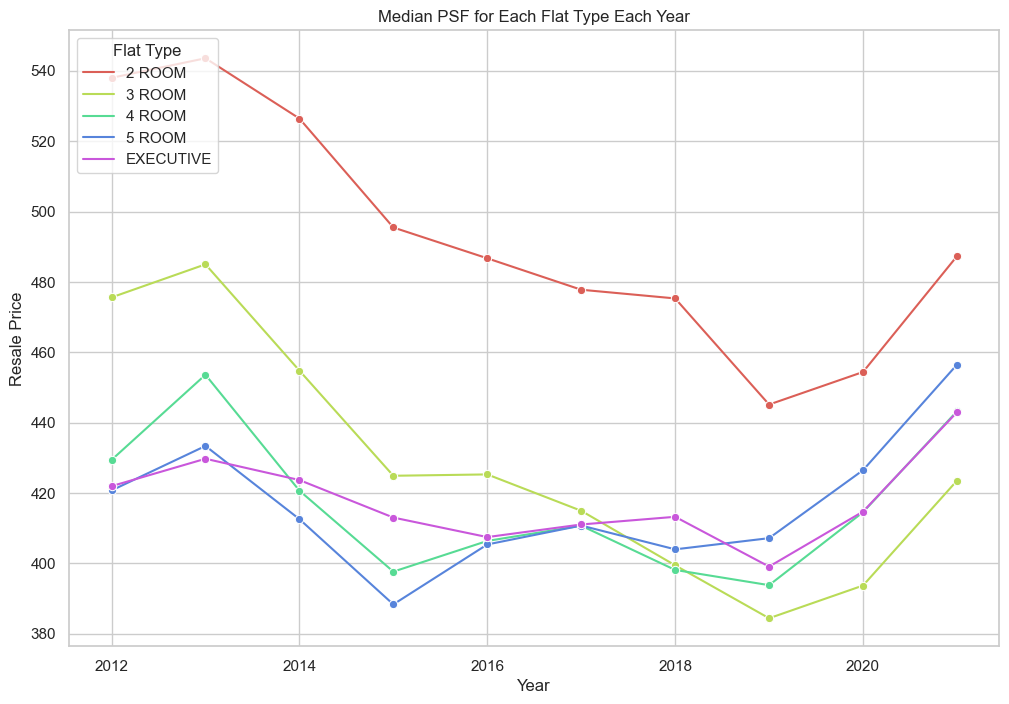

In [105]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Set the style of the plot

median_psf = hdb_graph_data.groupby(['tranc_year', 'flat_type'])['psf'].median().reset_index()

# Create a line plot with Seaborn
sns.lineplot(x='tranc_year', y='psf', hue='flat_type', data=median_psf, marker='o', palette='hls', ci=None)

plt.title('Median PSF for Each Flat Type Each Year')
plt.xlabel('Year')
plt.ylabel('Resale Price')
plt.legend(title='Flat Type', loc='upper left')
plt.show()

Unexplored, but interesting how 2 ROOM has a much higher PSF.

C:\Users\user\AppData\Local\Temp\ipykernel_17684\2039692100.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='tranc_year', y='resale_price', hue='flat_type', data=median_prices, marker='o', palette='hls', ci=None)


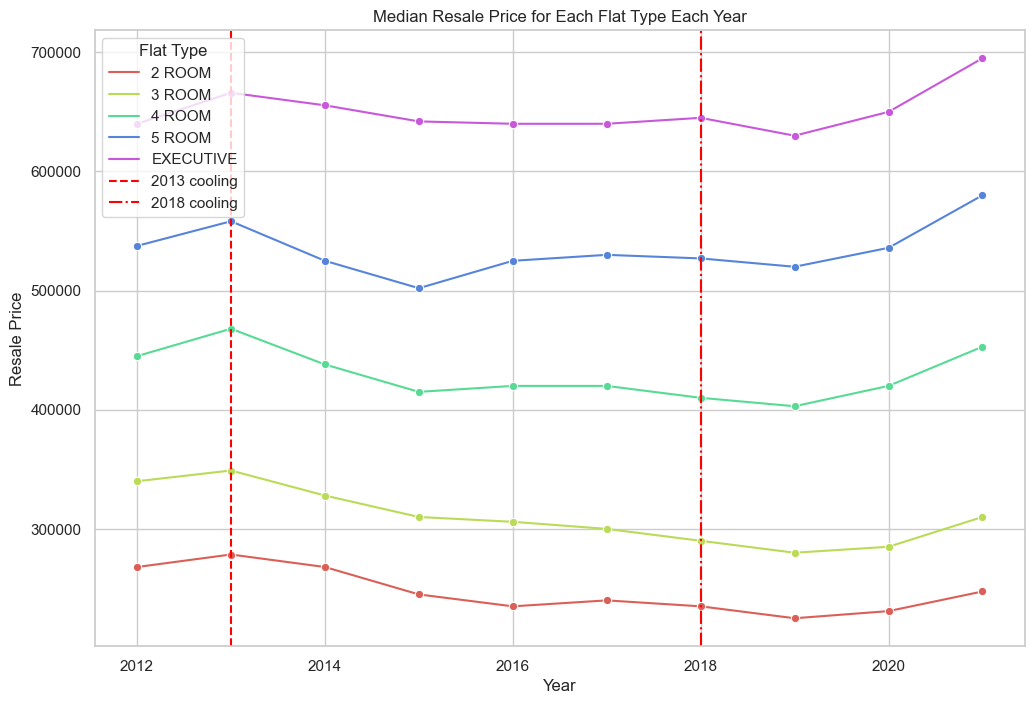

In [134]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Set the style of the plot

median_prices = hdb_graph_data.groupby(['tranc_year', 'flat_type'])['resale_price'].median().reset_index()

# Create a line plot with Seaborn
sns.lineplot(x='tranc_year', y='resale_price', hue='flat_type', data=median_prices, marker='o', palette='hls', ci=None)


plt.axvline(x=2013, color='red', linestyle='--', label='2013 cooling')
plt.axvline(x=2018, color='red', linestyle='-.', label='2018 cooling')


plt.title('Median Resale Price for Each Flat Type Each Year')
plt.xlabel('Year')
plt.ylabel('Resale Price')
plt.legend(title='Flat Type', loc='upper left')
plt.show()

This agrees with a CNA article on the cooling measures done in 2013 and 2018. The 2013 cooling measure was much more effective.

c:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

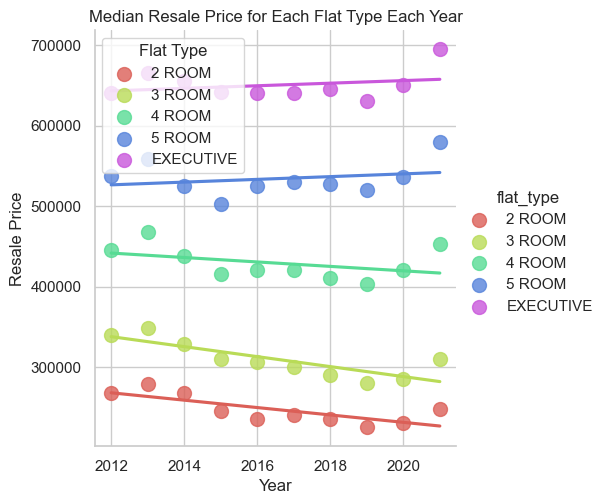

In [107]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Set the style of the plot

median_prices = hdb_graph_data.groupby(['tranc_year', 'flat_type'])['resale_price'].median().reset_index()

# Create a line plot with Seaborn
#sns.lineplot(x='tranc_year', y='resale_price', hue='flat_type', data=median_prices, marker='o', palette='hls', ci=None)

sns.lmplot(x='tranc_year', y='resale_price', hue='flat_type', data=median_prices, scatter_kws={'s': 100}, palette='hls', ci=None)


plt.title('Median Resale Price for Each Flat Type Each Year')
plt.xlabel('Year')
plt.ylabel('Resale Price')
plt.legend(title='Flat Type', loc='upper left')
plt.show()

Wanted to see if different flat types had different trends across the years

In [108]:
test_data.head()

id Tranc_YearMonth         town flat_type block          street_name  \
0  114982         2012-11       YISHUN    4 ROOM   173         YISHUN AVE 7   
1   95653         2019-08  JURONG WEST    5 ROOM  986C    JURONG WEST ST 93   
2   40303         2013-10   ANG MO KIO    3 ROOM   534    ANG MO KIO AVE 10   
3  109506         2017-10    WOODLANDS    4 ROOM    29         MARSILING DR   
4  100149         2016-08  BUKIT BATOK    4 ROOM   170  BT BATOK WEST AVE 8   

  storey_range  floor_area_sqm         flat_model  lease_commence_date  \
0     07 TO 09            84.0         Simplified                 1987   
1     04 TO 06           112.0  Premium Apartment                 2008   
2     07 TO 09            68.0     New Generation                 1980   
3     01 TO 03            97.0     New Generation                 1979   
4     16 TO 18           103.0            Model A                 1985   

   Tranc_Year  Tranc_Month  mid_storey  lower  upper  mid  \
0        2012           11           8      7      9    8   
1        2019            8           5      4      6    5   
2        2013           10           8      7      9    8   
3        2017           10           2      1      3    2   
4        2016            8          17     16     18   17   

             full_flat_type                   address  floor_area_sqft  \
0         4 ROOM Simplified         173, YISHUN AVE 7          904.176   
1  5 ROOM Premium Apartment   986C, JURONG WEST ST 93         1205.568   
2     3 ROOM New Generation    534, ANG MO KIO AVE 10          731.952   
3     4 ROOM New Generation          29, MARSILING DR         1044.108   
4            4 ROOM Model A  170, BT BATOK WEST AVE 8         1108.692   

   hdb_age  max_floor_lvl  year_completed residential commercial  \
0       34             12            1986           Y          Y   
1       13             14            2002           Y          N   
2       41             12            1979           Y          N   
3       42             14            1976           Y          N   
4       36             25            1985           Y          N   

  market_hawker multistorey_carpark precinct_pavilion  total_dwelling_units  \
0             N                   N                 N                   132   
1             N                   N                 N                    53   
2             N                   N                 N                   218   
3             N                   N                 N                   104   
4             N                   N                 N                   144   

   1room_sold  2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  \
0           0           0           0          92          40          0   
1           0           0           0          28          25          0   
2           0           0         191          22           1          1   
3           0           0           0         104           0          0   
4           0           0           0          48          96          0   

   multigen_sold  studio_apartment_sold  1room_rental  2room_rental  \
0              0                      0             0             0   
1              0                      0             0             0   
2              0                      0             0             0   
3              0                      0             0             0   
4              0                      0             0             0   

   3room_rental  other_room_rental  postal  Latitude   Longitude  \
0             0                  0  760173  1.437066  103.831121   
1             0                  0  643986  1.336957  103.695668   
2             3                  0  560534  1.374058  103.854168   
3             0                  0  731029  1.442748  103.772922   
4             0                  0  650170  1.346556  103.740101   

  planning_area  Mall_Nearest_Distance  Mall_Within_500m  Mall_Within_1km  \
0        Yishun      

In [109]:
hdb_predictions_data = pd.merge(train_data[train_data['source']=='Test'],predictions_results, on='id', how='left').drop(columns='resale_price')
hdb_predictions_data.rename(columns={"predicted":"resale_price"}, inplace=True)

hdb_predictions_data['psf'] = hdb_predictions_data['resale_price'] / hdb_predictions_data['floor_area_sqft']
hdb_predictions_data.head()

source      id    region_maturity flat_type model_category  tranc_year  \
0   Test  114982              NORTH    4 ROOM       Standard        2012   
1   Test   95653               WEST    5 ROOM       Standard        2019   
2   Test   40303  NORTH-EAST MATURE    3 ROOM       Standard        2013   
3   Test  109506              NORTH    4 ROOM       Standard        2017   
4   Test  100149               WEST    4 ROOM       Standard        2016   

   tranc_month  mid_storey  floor_area_sqft  units_per_floor  has_rental  \
0           11           8          904.176        11.000000           0   
1            8           5         1205.568         3.785714           0   
2           10           8          731.952        18.166667           1   
3           10           2         1044.108         7.428571           0   
4            8          17         1108.692         5.760000           0   

   mall_nearest_distance  mall_within_2km  hawker_nearest_distance  \
0             877.431572              4.0               687.576779   
1             534.037705              3.0              2122.346226   
2             817.050453              3.0               152.287621   
3            1272.737194              3.0               501.892158   
4            1070.963675              5.0               437.593564   

   hawker_within_2km  hawker_food_stalls  hawker_market_stalls  \
0                1.0                  56                   123   
1                0.0                  72                    94   
2               11.0                  50                   100   
3                2.0                  52                   112   
4                2.0                  60                    87   

   mrt_nearest_distance  bus_interchange  mrt_interchange  \
0            686.660434                0                0   
1            169.478175                0                0   
2            694.220448                1                0   
3           1117.203587                0                0   
4            987.976010                0                0   

   bus_stop_nearest_distance  pri_sch_nearest_distance  hdb_age_transaction  \
0                  75.683952                426.467910                   25   
1                  88.993058                439.756851                   11   
2                  86.303575                355.882207                   33   
3                 108.459039                929.744711                   38   
4                 113.645431                309.926934                   31   

   resale_price         psf  
0      344000.0  380.456902  
1      511000.0  423.866592  
2      371000.0  506.863838  
3      297000.0  284.453332  
4      408000.0  368.001212

In [110]:
hdb_graph_data.dtypes

id                             int64
region_maturity               object
flat_type                     object
model_category                object
resale_price                 float64
tranc_year                     int64
tranc_month                    int64
mid_storey                     int64
floor_area_sqft              float64
units_per_floor              float64
has_rental                     int32
mall_nearest_distance        float64
mall_within_2km              float64
hawker_nearest_distance      float64
hawker_within_2km            float64
hawker_food_stalls             int64
hawker_market_stalls           int64
mrt_nearest_distance         float64
bus_interchange                int64
mrt_interchange                int64
bus_stop_nearest_distance    float64
pri_sch_nearest_distance     float64
hdb_age_transaction            int64
psf                          float64
dtype: object

C:\Users\user\AppData\Local\Temp\ipykernel_17684\166055887.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='tranc_year', y='resale_price', hue='flat_type', data=median_prices, marker='o', palette='hls', ci=None)


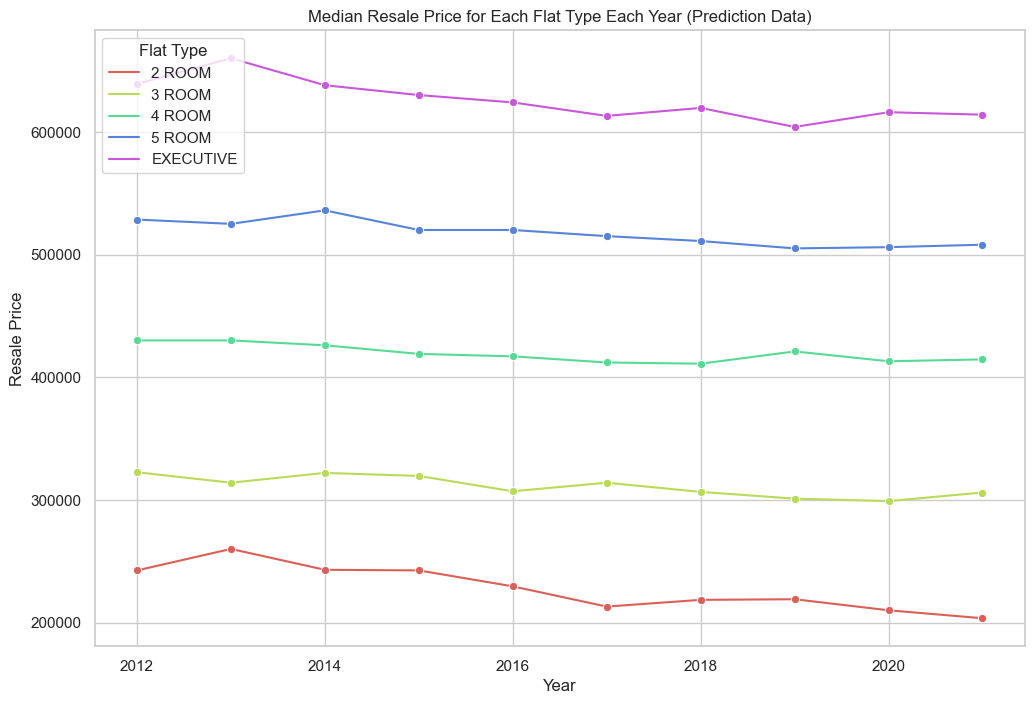

In [111]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Set the style of the plot

median_prices = hdb_predictions_data.groupby(['tranc_year', 'flat_type'])['resale_price'].median().reset_index()

# Create a line plot with Seaborn
sns.lineplot(x='tranc_year', y='resale_price', hue='flat_type', data=median_prices, marker='o', palette='hls', ci=None)

plt.title('Median Resale Price for Each Flat Type Each Year (Prediction Data)')
plt.xlabel('Year')
plt.ylabel('Resale Price')
plt.legend(title='Flat Type', loc='upper left')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17684\4205482520.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='mid_storey', y='resale_price', hue='flat_type', data=median_prices, marker='o', palette='hls', ci=None)


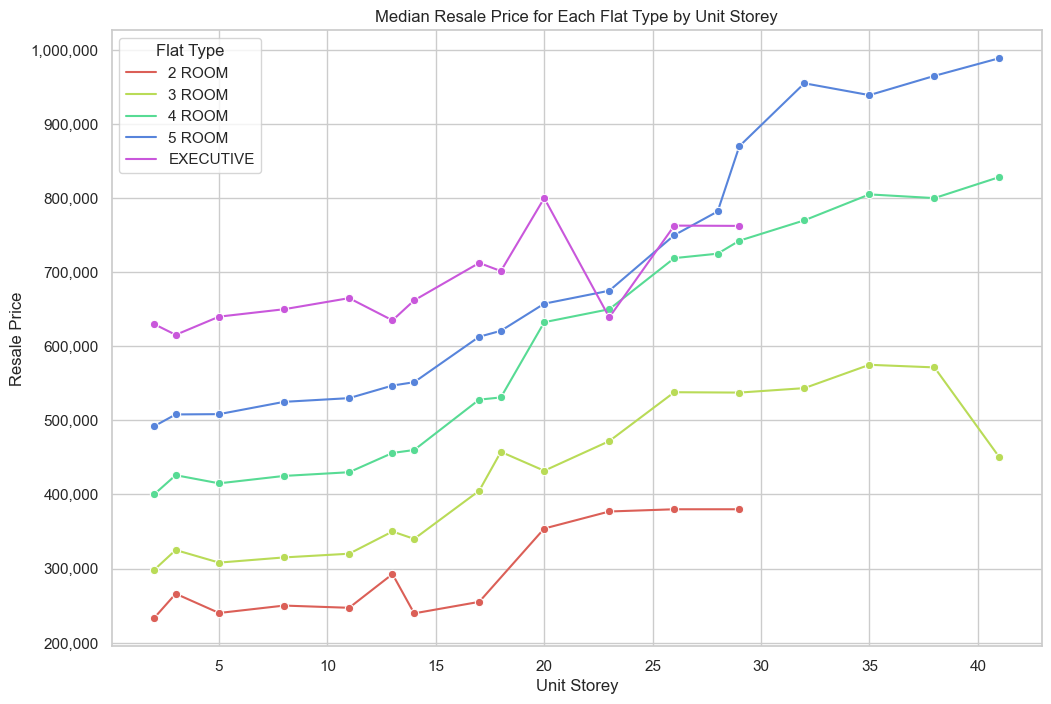

In [112]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Set the style of the plot

median_prices = hdb_graph_data.groupby(['mid_storey', 'flat_type'])['resale_price'].median().reset_index()

# Create a line plot with Seaborn
sns.lineplot(x='mid_storey', y='resale_price', hue='flat_type', data=median_prices, marker='o', palette='hls', ci=None)

plt.title('Median Resale Price for Each Flat Type by Unit Storey')
plt.xlabel('Unit Storey')
plt.ylabel('Resale Price')
plt.legend(title='Flat Type', loc='upper left')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.show()

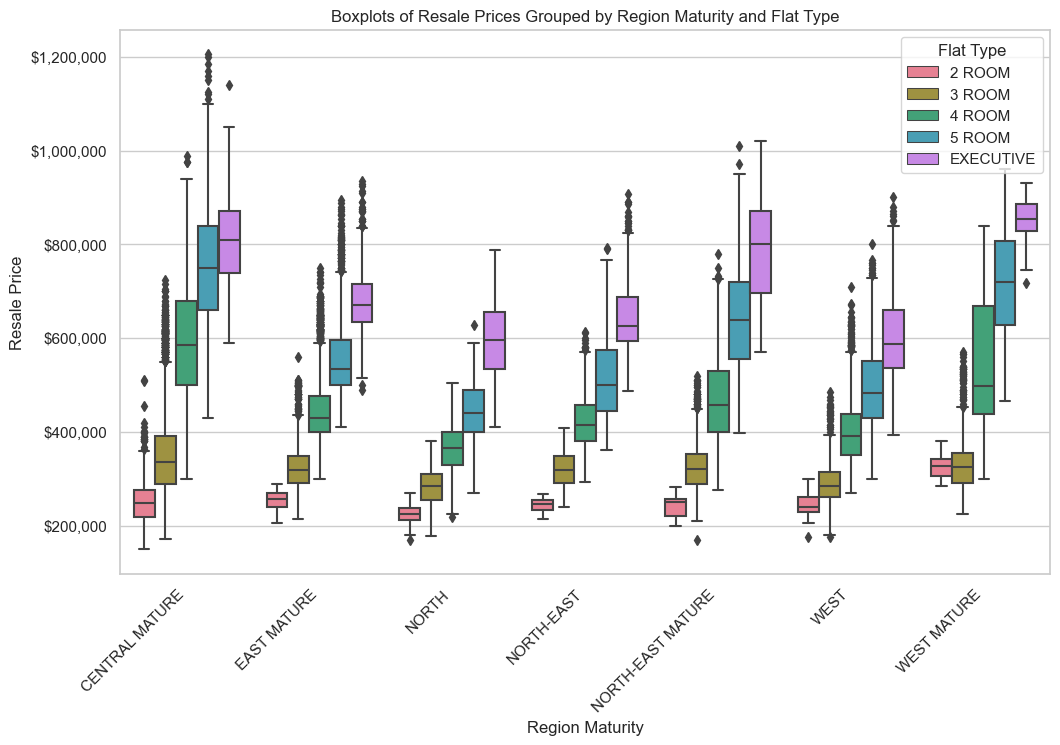

In [113]:
hdb_graph_data['region_maturity'] = pd.Categorical(hdb_graph_data['region_maturity'], categories=sorted(hdb_graph_data['region_maturity'].unique()))
hdb_graph_data['flat_type'] = pd.Categorical(hdb_graph_data['flat_type'], categories=sorted(hdb_graph_data['flat_type'].unique()))

# Use Seaborn for boxplots
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Set the style of the plot

# Create boxplots with Seaborn
sns.boxplot(x='region_maturity', y='resale_price', hue='flat_type', data=hdb_graph_data, palette='husl')

# Customize x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees to the right
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to make room for rotated labels

plt.title('Boxplots of Resale Prices Grouped by Region Maturity and Flat Type')
plt.xlabel('Region Maturity')
plt.ylabel('Resale Price')
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
plt.legend(title='Flat Type', loc='upper right')
plt.show()

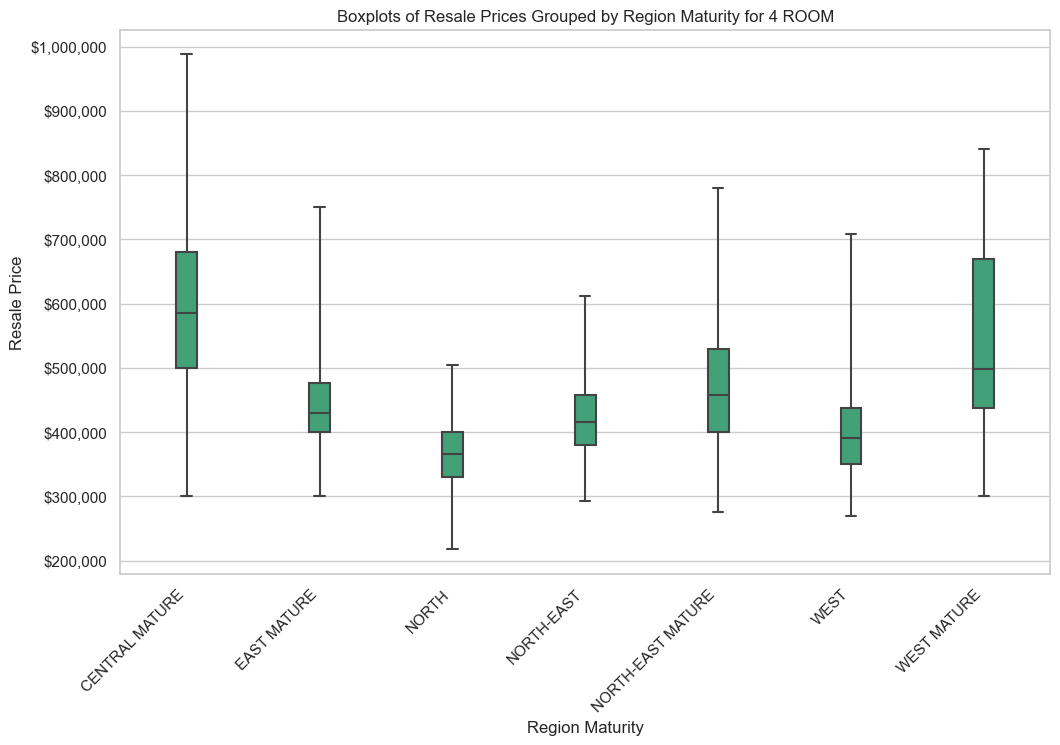

In [114]:
hdb_graph_data['region_maturity'] = pd.Categorical(hdb_graph_data['region_maturity'], categories=sorted(hdb_graph_data['region_maturity'].unique()))
hdb_graph_data['flat_type'] = pd.Categorical(hdb_graph_data['flat_type'], categories=sorted(hdb_graph_data['flat_type'].unique()))

# Use Seaborn for boxplots
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Set the style of the plot

filtered_data = hdb_graph_data[hdb_graph_data['flat_type'] == '4 ROOM']

# Create boxplots with Seaborn
sns.boxplot(x='region_maturity', y='resale_price', hue='flat_type', data=filtered_data, palette='husl', whis=(0,100))

# Customize x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees to the right
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to make room for rotated labels

plt.title('Boxplots of Resale Prices Grouped by Region Maturity for 4 ROOM')
plt.xlabel('Region Maturity')
plt.ylabel('Resale Price')
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
plt.legend().set_visible(False)
#plt.legend(title='Flat Type', loc='upper right')
plt.show()

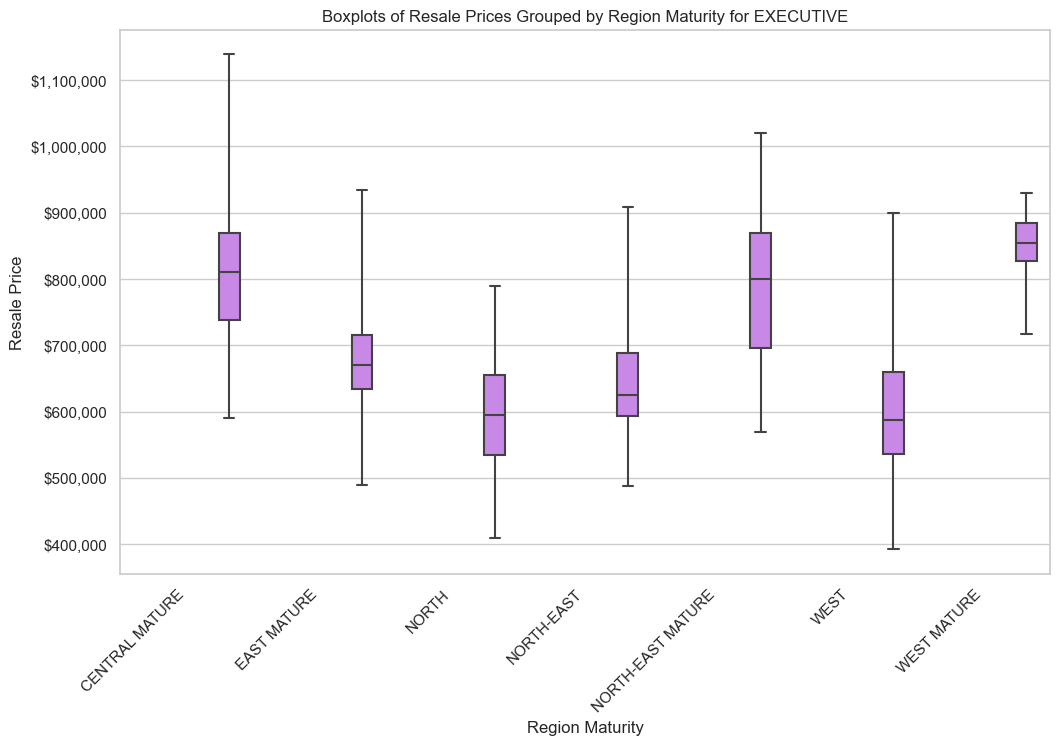

In [115]:
hdb_graph_data['region_maturity'] = pd.Categorical(hdb_graph_data['region_maturity'], categories=sorted(hdb_graph_data['region_maturity'].unique()))
hdb_graph_data['flat_type'] = pd.Categorical(hdb_graph_data['flat_type'], categories=sorted(hdb_graph_data['flat_type'].unique()))

# Use Seaborn for boxplots
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Set the style of the plot

filtered_data = hdb_graph_data[hdb_graph_data['flat_type'] == 'EXECUTIVE']

# Create boxplots with Seaborn
sns.boxplot(x='region_maturity', y='resale_price', hue='flat_type', data=filtered_data, palette='husl', whis=(0,100))

# Customize x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees to the right
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to make room for rotated labels

plt.title('Boxplots of Resale Prices Grouped by Region Maturity for EXECUTIVE')
plt.xlabel('Region Maturity')
plt.ylabel('Resale Price')
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
plt.legend().set_visible(False)
#plt.legend(title='Flat Type', loc='upper right')
plt.show()

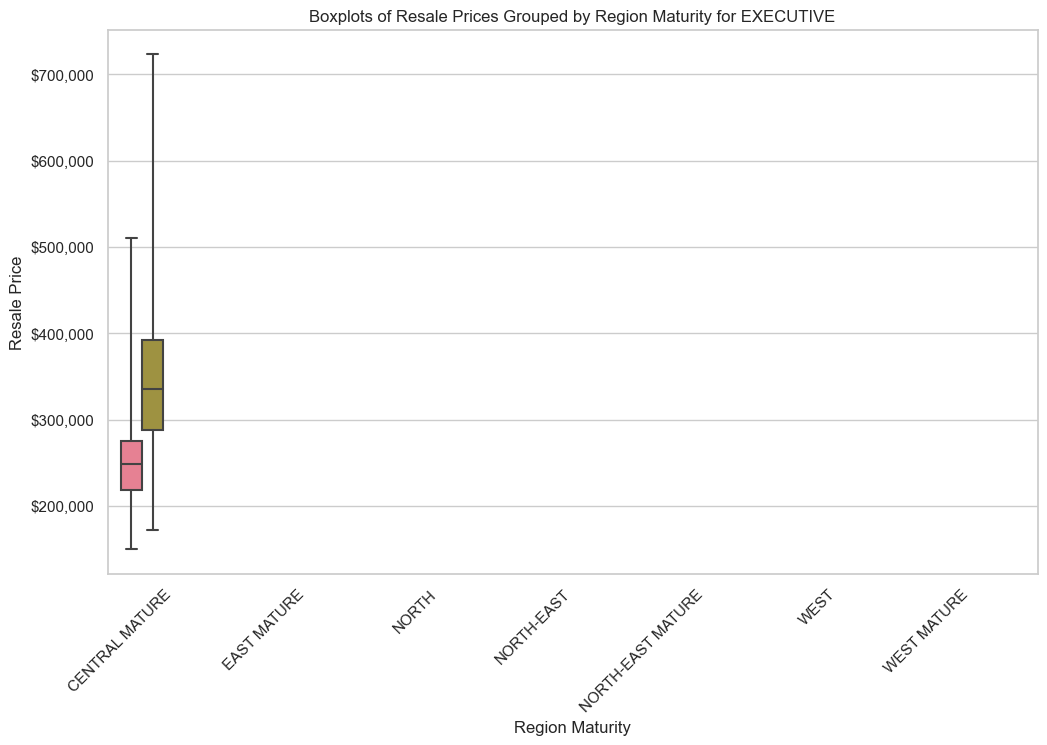

In [116]:
hdb_graph_data['region_maturity'] = pd.Categorical(hdb_graph_data['region_maturity'], categories=sorted(hdb_graph_data['region_maturity'].unique()))
hdb_graph_data['flat_type'] = pd.Categorical(hdb_graph_data['flat_type'], categories=sorted(hdb_graph_data['flat_type'].unique()))

# Use Seaborn for boxplots
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Set the style of the plot

filtered_data = hdb_graph_data[((hdb_graph_data['flat_type'] == '2 ROOM') | (hdb_graph_data['flat_type'] == '3 ROOM')) & ((hdb_graph_data['region_maturity'] == 'CENTRAL MATURE'))]

# Create boxplots with Seaborn
sns.boxplot(x='region_maturity', y='resale_price', hue='flat_type', data=filtered_data, palette='husl', whis=(0,100))

# Customize x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees to the right
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to make room for rotated labels

plt.title('Boxplots of Resale Prices Grouped by Region Maturity for EXECUTIVE')
plt.xlabel('Region Maturity')
plt.ylabel('Resale Price')
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
plt.legend().set_visible(False)
#plt.legend(title='Flat Type', loc='upper right')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17684\1912048448.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='tranc_year', y='resale_price', hue='flat_type', style='dataset', data=combined_data, marker='o', palette='hls', ci=None)


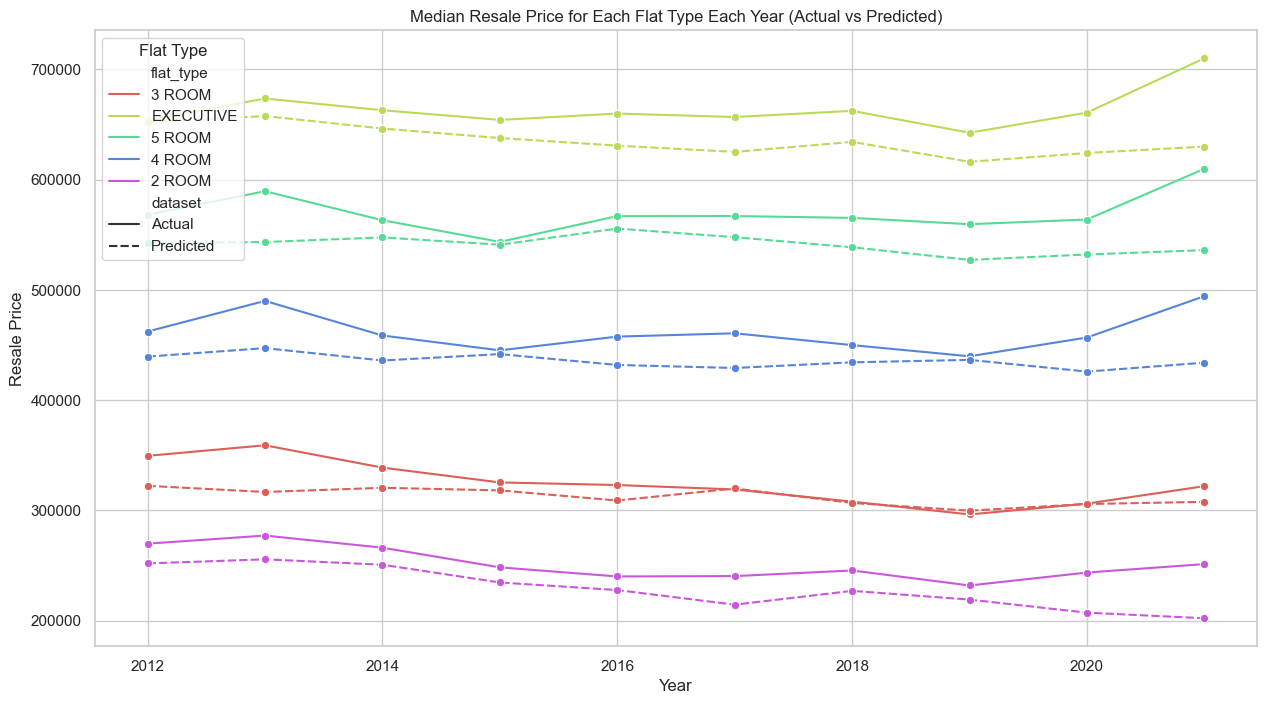

In [117]:
hdb_graph_data['dataset'] = 'Actual'
hdb_predictions_data['dataset'] = 'Predicted'

# Combine both DataFrames
combined_data = pd.concat([hdb_graph_data, hdb_predictions_data])

# Use Seaborn for a more visually appealing plot
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")  # Set the style of the plot

# Create a line plot with Seaborn
sns.lineplot(x='tranc_year', y='resale_price', hue='flat_type', style='dataset', data=combined_data, marker='o', palette='hls', ci=None)

plt.title('Median Resale Price for Each Flat Type Each Year (Actual vs Predicted)')
plt.xlabel('Year')
plt.ylabel('Resale Price')
plt.legend(title='Flat Type', loc='upper left')
plt.show()

Curiousity to visualise our prediction. Though this will be dependent on whether the test.csv data was randomly sampled or if there was bias.

C:\Users\user\AppData\Local\Temp\ipykernel_17684\1903678831.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='region_maturity', y='resale_price', hue='flat_type', style='dataset', data=combined_data, marker='o', palette='hls', ci=None)


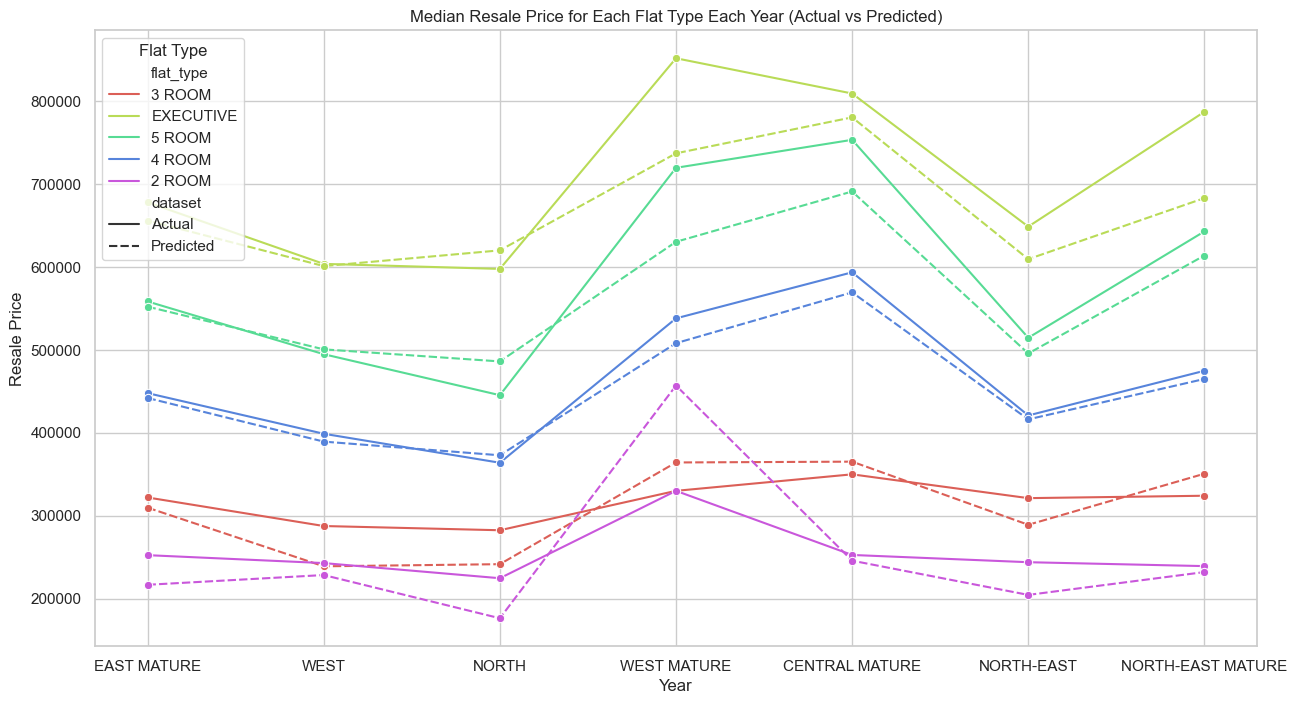

In [118]:
hdb_graph_data['dataset'] = 'Actual'
hdb_predictions_data['dataset'] = 'Predicted'

# Combine both DataFrames
combined_data = pd.concat([hdb_graph_data, hdb_predictions_data])

# Use Seaborn for a more visually appealing plot
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")  # Set the style of the plot

# Create a line plot with Seaborn
sns.lineplot(x='region_maturity', y='resale_price', hue='flat_type', style='dataset', data=combined_data, marker='o', palette='hls', ci=None)

plt.title('Median Resale Price for Each Flat Type Each Year (Actual vs Predicted)')
plt.xlabel('Year')
plt.ylabel('Resale Price')
plt.legend(title='Flat Type', loc='upper left')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17684\3573833151.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='region_maturity', y='resale_price', hue='flat_type', data=filtered_data, marker='o', palette='hls', ci=None)


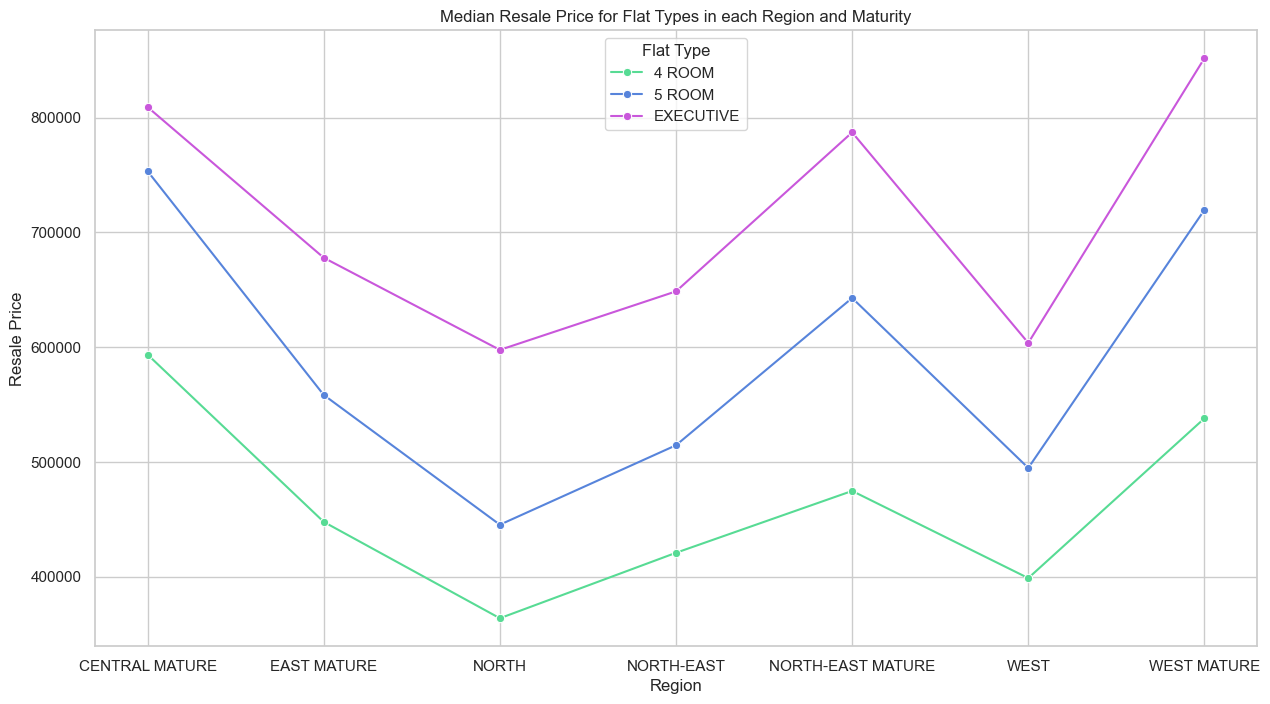

In [119]:
filtered_data = hdb_graph_data[(hdb_graph_data['flat_type'] =='4 ROOM') | (hdb_graph_data['flat_type'] =='5 ROOM') | (hdb_graph_data['flat_type'] =='EXECUTIVE')]

# Use Seaborn for a more visually appealing plot
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")  # Set the style of the plot

# Create a line plot with Seaborn
sns.lineplot(x='region_maturity', y='resale_price', hue='flat_type', data=filtered_data, marker='o', palette='hls', ci=None)

plt.title('Median Resale Price for Flat Types in each Region and Maturity')
plt.xlabel('Region')
plt.ylabel('Resale Price')
plt.legend(title='Flat Type', labels=['4 ROOM', '5 ROOM', 'EXECUTIVE'], loc='upper center')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17684\2049690086.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='region_maturity', y='resale_price', hue='flat_type', data=hdb_graph_data, marker='o', palette='hls', ci=None)


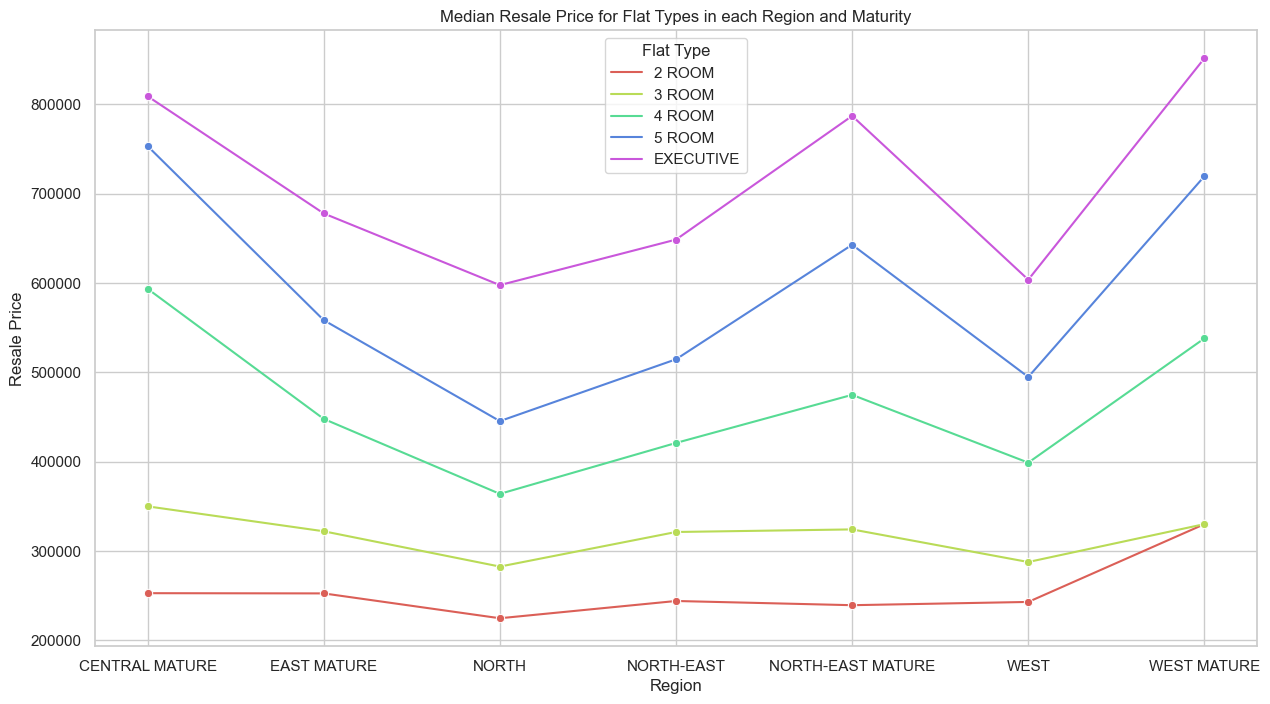

In [120]:
#filtered_data = hdb_graph_data[(hdb_graph_data['flat_type'] =='4 ROOM') | (hdb_graph_data['flat_type'] =='5 ROOM') | (hdb_graph_data['flat_type'] =='EXECUTIVE')]

# Use Seaborn for a more visually appealing plot
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")  # Set the style of the plot

# Create a line plot with Seaborn
sns.lineplot(x='region_maturity', y='resale_price', hue='flat_type', data=hdb_graph_data, marker='o', palette='hls', ci=None)

plt.title('Median Resale Price for Flat Types in each Region and Maturity')
plt.xlabel('Region')
plt.ylabel('Resale Price')
plt.legend(title='Flat Type', loc='upper center')
plt.show()

### Conclusions and Recommendations

Based on the model, data exploration, and visualisations, it is evident that the region and maturity of the town that the HDB unit is located in is the most signifcant factor that affects resale prices of HDB units. The North and West regions, and non-mature towns cost lesser. Following which, the unit specifications such as flat type and flat model are the next most significant features.

Based on our problem statement, we came up with recommendations for 3 potential groups of buyers: 
1. Budget-conscious
- To consider purchasing units in the North region of Singapore as it generally has the lowest prices compared to the other regions, if location is not a concern
- Likely due to towns in the North are non mature

2. Family-oriented
- To consider 4-room, 5-room and executive flat types 
- Can still cost-save by considering units the North, West and North-east regions

3. Design-conscious
- To consider looking at flat models instead of flat types and locations
- Maisonette and private built flat models have bigger floor area, "luxrious feel"
- However the trade-off is that prices might be higher than the standard HDB units

However there are also other potential factors that buyers can consider, based on domain knowledge, which are not in our dataset
- Noise i.e. surrounding ambient noise of the unit
- HDB measures i.e. cooling measures, eligibility controls, ethnic quotas
- Other preferential & community features i.e. corner units, orientation of unit, proximity to community amenities

For this project, we worked solely with the data available from the dataset. But this can be improved by adding other features that are supported by external research.
